# Apprentissage non supervisé (clustering)
## 10% de dataset `20newsgroups` **sans** stopwords
**Remarque** : on applique le clustering uniquement sur le dataset **sans** stopwords. Dans l'apprentissage supervisé (voir les fichiers `supervised_no_sw.ipynb` et `supervised_sw.ipynb`) on a vu que les stopwords ont apporté rien de nouveau (pas d'amélioration en accuracy) et ont dégradé la performance pour la plupart des classifieurs.

De plus, on verra par la suite qu'on est obligé de réduire la dimension pour K-means donc c'est mieux de garder que les mots qui apportent plus d'information que les stopwords.

In [1]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import sys
sys.path.append('../') 

from iads import Classifiers as classif

from iads import utils as ut

from iads import evaluation as ev

from iads import Clustering as clust

from iads.vectorization import get_bow_vect, get_tfidf_vect, normalize

from iads.preprocessing import get_corpus, clean_news, lemmatize_filter

import iads.clustering_eval as ce

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2
%matplotlib inline  

sns.set_theme()
plt.rcParams['font.family'] = 'Proxima Nova'

## Chargement de données et prétraitement

In [2]:
newsgroups_df = pd.read_csv("data/sample.csv")
stop_words_df = pd.read_csv("data/stopwords.csv")
stopwords = stop_words_df["stopword"].values.tolist()

news_no_stopwords = clean_news(newsgroups_df, stopwords, True, True)
news_no_stopwords = lemmatize_filter(news_no_stopwords, 3, 10)
corpus = get_corpus(news_no_stopwords)
news_no_stopwords

Number of Nans 48


,Message index,target,label,messages
0,0,0,alt.atheism,law seem value criminal life victim life islam...
1,1,0,alt.atheism,com bill newsgroups alt atheism organization s...
2,2,0,alt.atheism,true believer die belief jesus jim jones well ...
3,3,0,alt.atheism,knowing keith expect bring better oil well dry
4,4,0,alt.atheism,film medium alternative movie source may book ...
...,...,...,...,...
1810,1879,19,comp.os.ms-windows.misc,think mistaken thinking tom atheist find athei...
1811,1881,19,comp.os.ms-windows.misc,would religious belief therefore feel comforta...
1812,1882,19,comp.os.ms-windows.misc,extremely good example evidence every time rig...
1813,1883,19,comp.os.ms-windows.misc,vol part ocean translation turkish writing sai...


### Distribution de longueurs des messages
Par la suite on va appliquer PCA pour réduire la dimension. PCA fonctionnait mal sans la normalization des vecteurs.

Le graphique ci-dessous montre qu'il existe des messages de longueur > 1000, donc pour rendre tous les messages comparables on fera la normalisation de chaque vecteur (message).

Text(0.5, 0.98, 'Distribution des longueurs des messages')

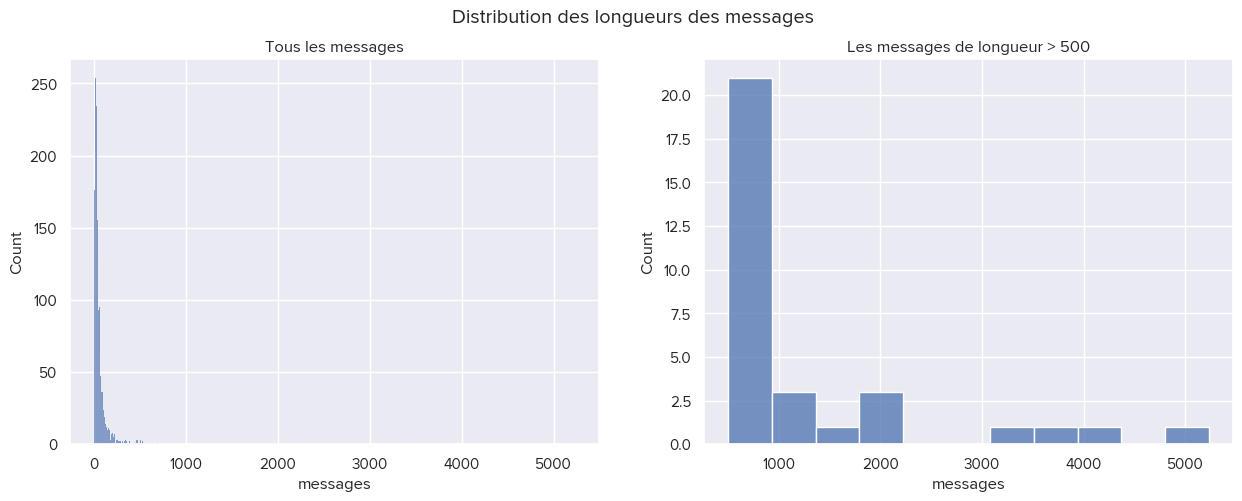

In [21]:
length = news_no_stopwords["messages"].str.split().apply(len)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(length, bins="auto", stat="count", ax=ax1)
ax1.set_title("Tous les messages")

sns.histplot(length[length > 500], bins="auto", stat="count", ax=ax2)
ax2.set_title("Les messages de longueur > 500")

fig.suptitle("Distribution des longueurs des messages")

Avant de procéder à l'évaluation des clusters, il faut remarquer que la dimension est très grande et, de plus, la distance euclidienne souffre d'un fléau de la dimension : les points deviennent équidistants et, par conséquent, le clustering par K-means basé sur la distance euclidienne aura une mauvaise performance. 

Pour voir ce qui se passe avec les distance entre les points, on plotte la distribution des distances euclidiennes des points entre eux.

**Remarque** : les vecteurs associés aux messages sont normalisées selon la norme L2 (norme euclidienne), i.e. la norme de chaque vecteur vaut 1.

Cette normalisation est également intéressante car elle permettra de faire K-means sur la distance cosinus, qui a donné de meilleurs résultats de classification que la distance euclidienne.
En effet, si les vecteurs $x, y$ sont de norme 1, alors
$$d_{eucl}(x, y) = \sqrt{x^2 - 2xy + y^2} = \sqrt{d_{cos}(x, x) - 2d_{cos}(x, y) + d_{cos}(y, y)} = \sqrt{2d_{cos}(x, y)}$$

La fonction $\sqrt{\cdot}$ est croissante, donc la distance euclidienne sur les vecteurs normalisées est proportionnelle à la racine carrée de la distance cosinus.

### Distribution des distances entre tous les points (distances par paire)

Text(0.5, 0.98, 'Distribution des distances entres les points')

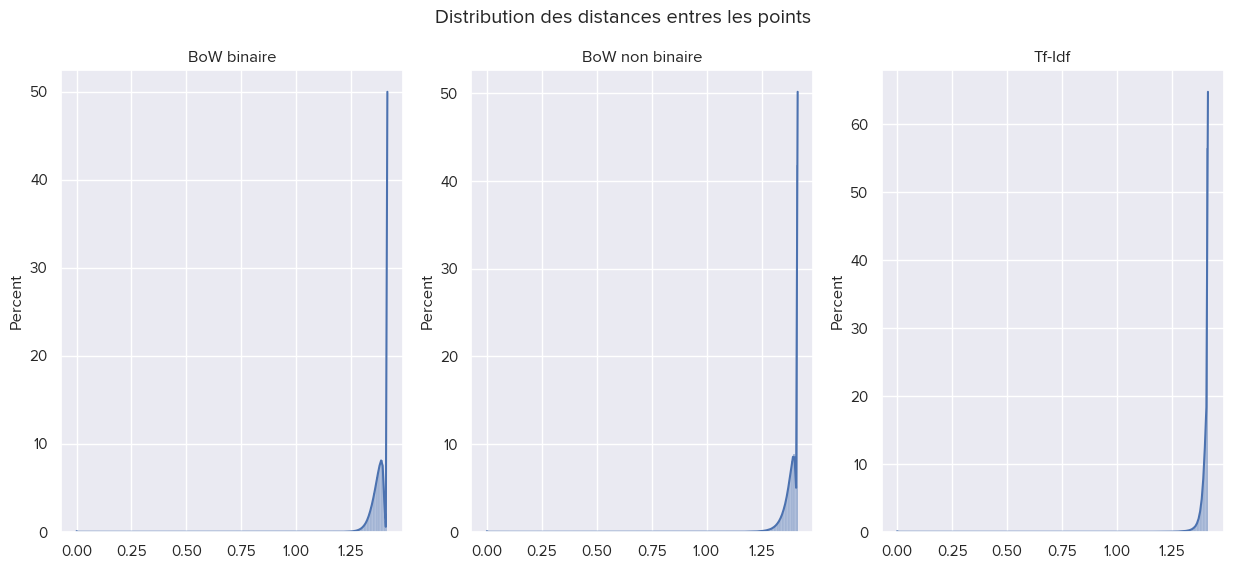

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))
distances = pairwise_distances(news_desc).flatten()
sns.histplot(distances, ax=ax1, bins=200, kde=True, stat="percent")
ax1.set_title("BoW binaire")

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=False))
distances = pairwise_distances(news_desc).flatten()
sns.histplot(distances, ax=ax2, bins=200, kde=True, stat="percent")
ax2.set_title("BoW non binaire")

news_desc = normalize(get_tfidf_vect(news_no_stopwords, corpus))
distances = pairwise_distances(news_desc).flatten()
sns.histplot(distances, ax=ax3, bins=200, kde=True, stat="percent")
ax3.set_title("Tf-Idf")

fig.suptitle("Distribution des distances entres les points")

En effet, 50% de tous les distances entre les points sont très proches.

Si on prend $k=20$ pour KMeans (et, par exemple, la vectorisation bow binaire), alors on obtient une distribution des points et des targets très déséquilibrée : la plupart des points (messages) sont dans le même cluster. Cela est la conséquence directe du fléau de dimension.

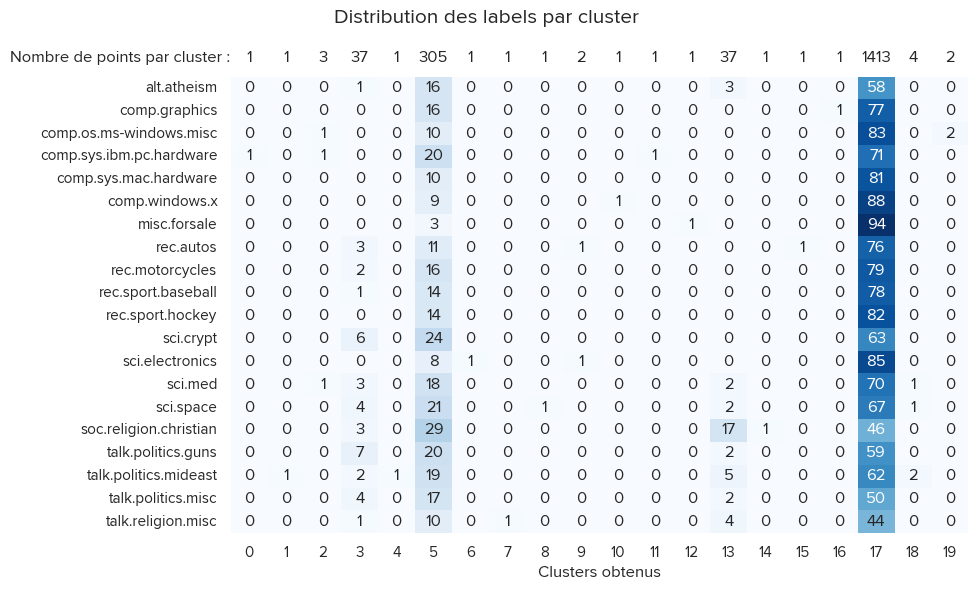

In [23]:
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=True).toarray()
centroids, affectation = clust.kmoyennes(20, news_desc, 0, 1000, False)
affectation = ce.predict_label(affectation)
fig = ce.distribution_target(news_no_stopwords['target'].values, affectation, news_no_stopwords['label'].values)

Afin de résoudre ce problème, on effectue la réduction de dimensionnalité à l'aide de PCA. Il nous faut de déterminer le nombre de composantes qui permettent d'expliquer, par exemple, $95\%$ de la variance. Vu que PCA est sensible à l'échelle des vecteurs, on doir également normaliser chaque vecteur (message) pour qu'il soit de norme 1.

In [ ]:
news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))
print("Bow binaire, n_components:", ce.get_n_components_PCA(news_desc, 0.95))

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=False))
print("Bow non binaire, n_components:", ce.get_n_components_PCA(news_desc, 0.95))

news_desc = normalize(get_tfidf_vect(news_no_stopwords, corpus))
print("Tf-Idf, n_components:", ce.get_n_components_PCA(news_desc, 0.95))

In [24]:
bow_bin_pca, bow_non_bin_pca, tfidf_pca = 1132, 1109, 1249

Text(0.5, 0.98, 'Distribution des distances entres les points')

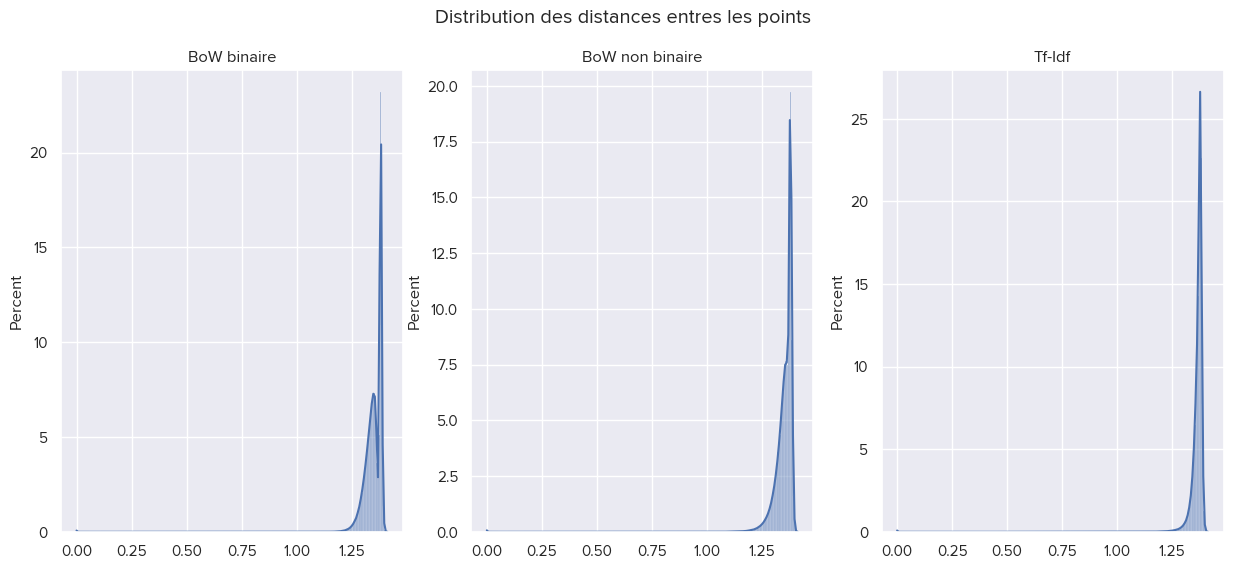

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))
model = PCA(n_components=bow_bin_pca)
m_pca = model.fit_transform(news_desc)
distances = pairwise_distances(m_pca).flatten()
sns.histplot(distances, ax=ax1, bins=200, kde=True, stat="percent")
ax1.set_title("BoW binaire")

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=False))
model = PCA(n_components=bow_non_bin_pca)
m_pca = model.fit_transform(news_desc)
distances = pairwise_distances(m_pca).flatten()
sns.histplot(distances, ax=ax2, bins=200, kde=True, stat="percent")
ax2.set_title("BoW non binaire")

news_desc = normalize(get_tfidf_vect(news_no_stopwords, corpus))
model = PCA(n_components=tfidf_pca)
m_pca = model.fit_transform(news_desc)
distances = pairwise_distances(m_pca).flatten()
sns.histplot(distances, ax=ax3, bins=200, kde=True, stat="percent")
ax3.set_title("Tf-Idf")

fig.suptitle("Distribution des distances entres les points")

La réduction avec PCA a permis d'avoir une meilleure distribution de distance (on est passé de 50% à ~20% pour les distances les plus élevées) et en même temps d'expliquer $95\%$ de la variance.

Ensuite, pour comparer, on applique KMeans sur ces données réduites. On verra que la répartition par cluster est beaucoup mieux qu'avant PCA. On va donc procéder avec la réduction de la dimensionnalité.

### Bag-of-words binaire
La distribution des points par cluster est beaucoup mieux qu'avant PCA.

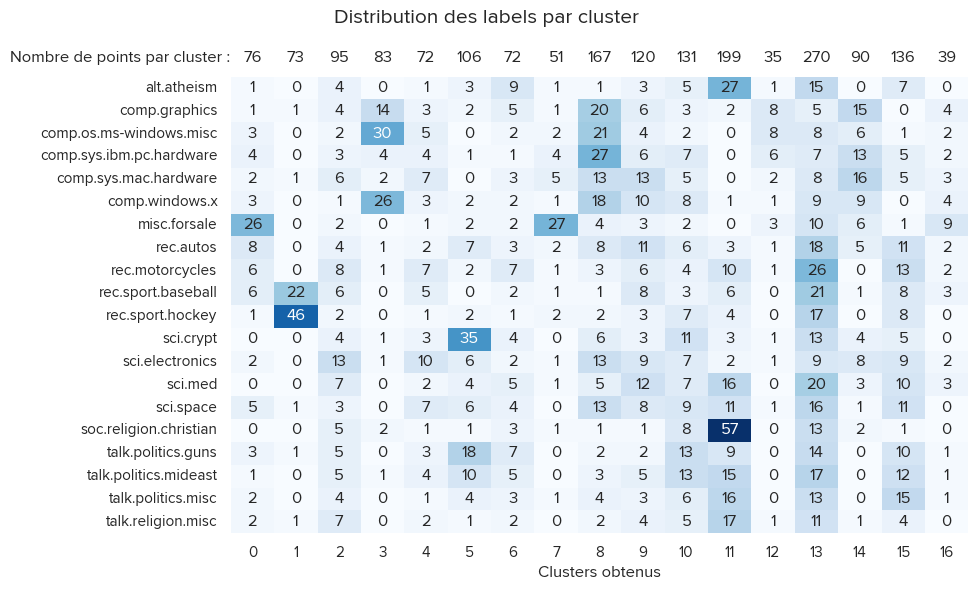

In [27]:
random.seed(1)
np.random.seed(1)

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))
model = PCA(n_components=bow_bin_pca, random_state=1)
m_pca = model.fit_transform(news_desc)
centroids, affectation = clust.kmoyennes(17, m_pca, 0, 1000, False)
affectation = ce.predict_label(affectation)
fig = ce.distribution_target(news_no_stopwords['target'].values, affectation, news_no_stopwords['label'].values)

## Métriques en fonction de $k$ dans un algorithme K-means

### Choix et définition des métriques:
Soit $k$ le nombre de clusters et $\mu_i$ le centroide d'un cluster $C_i$
- compacité : inertie globale (minimiser)
$$\sum_{i=1}^k\sum_{x\in C_i} ||x - \mu_i||²$$

- co-distance : (minimiser)
$$\sum_{i=1}^k\sum_{x\in C_i} ||x - \mu_i||$$

- séparabilité : (maximiser)
 $$\sum_{i<j} ||\mu_i - \mu_j||$$

(définition du cours)
- Xie-Beni : (minimiser)
$$ \dfrac{\text{inertie globale}}{\text{min}_{i\neq j}||\mu_i - \mu_j||}$$

- Dunn : (minimiser)
$$ \dfrac{\text{co-distance}}{\text{min}_{i\neq j}||\mu_i - \mu_j||}$$

## K-means

### Bag-of-words binaire

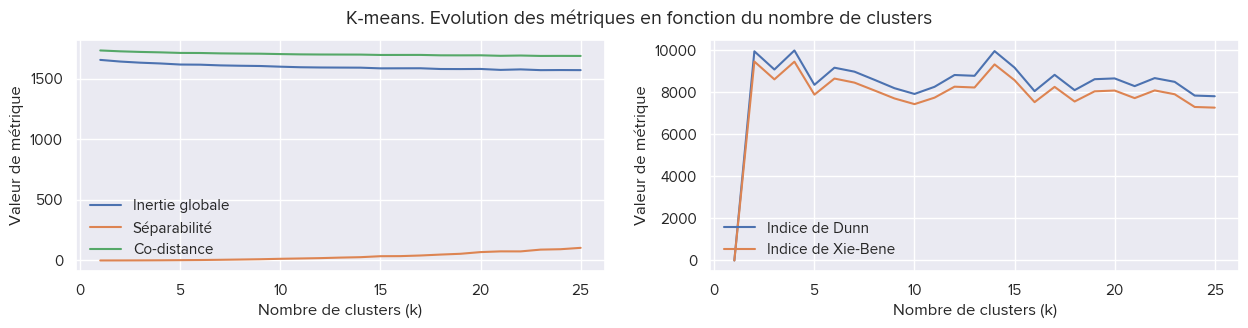

In [6]:
random.seed(1)
np.random.seed(1)
news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))
m_pca = PCA(n_components=bow_bin_pca, random_state=1).fit_transform(news_desc)
k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index = ce.variation_k_evalution(m_pca)
fig = ce.scores_plot("K-means. Evolution des métriques en fonction du nombre de clusters",
                  k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index)
fig.savefig("images/no_sw/kmeans_clusters/bow_bin_metrics.svg", dpi=150, bbox_inches='tight', format="svg")

### Bag-of-words non binaire

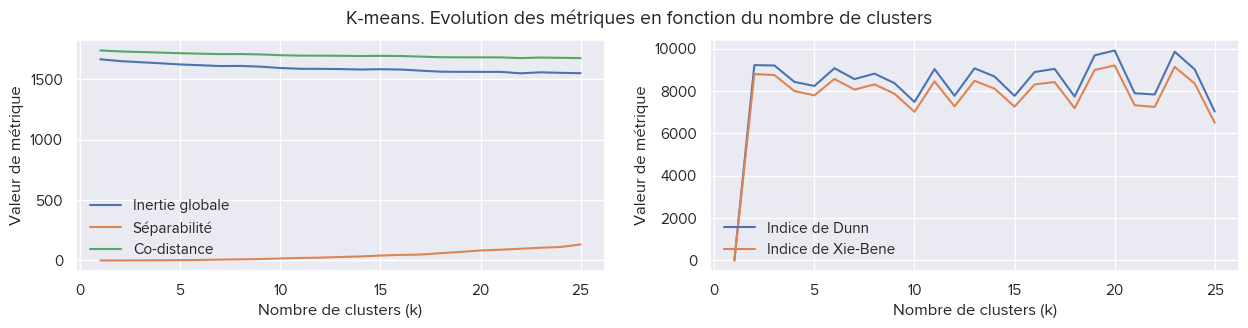

In [7]:
random.seed(1)
np.random.seed(1)

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=False))
m_pca = PCA(n_components=bow_non_bin_pca, random_state=1).fit_transform(news_desc)
k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index = ce.variation_k_evalution(m_pca)
fig = ce.scores_plot("K-means. Evolution des métriques en fonction du nombre de clusters",
                  k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index)
fig.savefig("images/no_sw/kmeans_clusters/bow_non_bin_metrics.svg", dpi=150, bbox_inches='tight', format="svg")

### TF-IDF

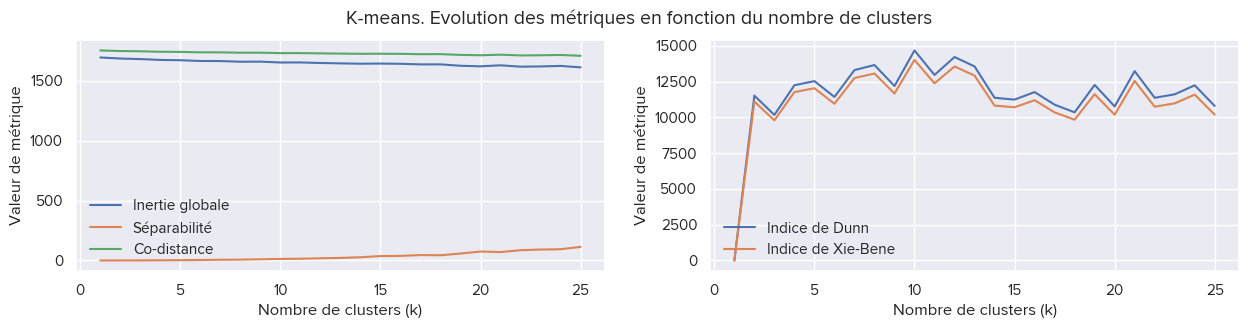

In [8]:
random.seed(1)
np.random.seed(1)

news_desc = normalize(get_tfidf_vect(news_no_stopwords, corpus))
m_pca = PCA(n_components=tfidf_pca, random_state=1).fit_transform(news_desc)
k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index = ce.variation_k_evalution(m_pca)
fig = ce.scores_plot("K-means. Evolution des métriques en fonction du nombre de clusters",
                  k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index)
fig.savefig("images/no_sw/kmeans_clusters/tfidf_metrics.svg", dpi=150, bbox_inches='tight', format="svg")

Pour tous les types de vectorisation K-Means $k=18$ a eu l'une des meilleurs valeurs des indices Dunn et Xie-Beni. Par conséquent, on posera $k=18$ pour le clustering K-Means (voir la suite dans le fichier `visualization.ipynb` où on visualise aussi les données et les clusters)
***

## Clustering hierarchique

### Bag-of-Words binaire

**Remarque** : on a appliqué le clustering hiérarchique sur les vecteurs (messages) et ça prenait trop de temps. Par conséquent, on applique le clustering hierarchique sur les targets.

La vectorisation des targets est obtenue en prenant les moyennes des vecteurs (messages) qui ont ce target.

On a vu également que la distance cosinus marche mieux pour la classification (voir les fichiers `supervised_no_sw.ipynb`) et en générale cette distance performe mieux pour les documents car elle regarde où pointe les vecteurs. Donc, pour les méthodes `single, complete, average` on utilise la distance cosinus, et pour `centroid` on utilise la distance euclidienne. 

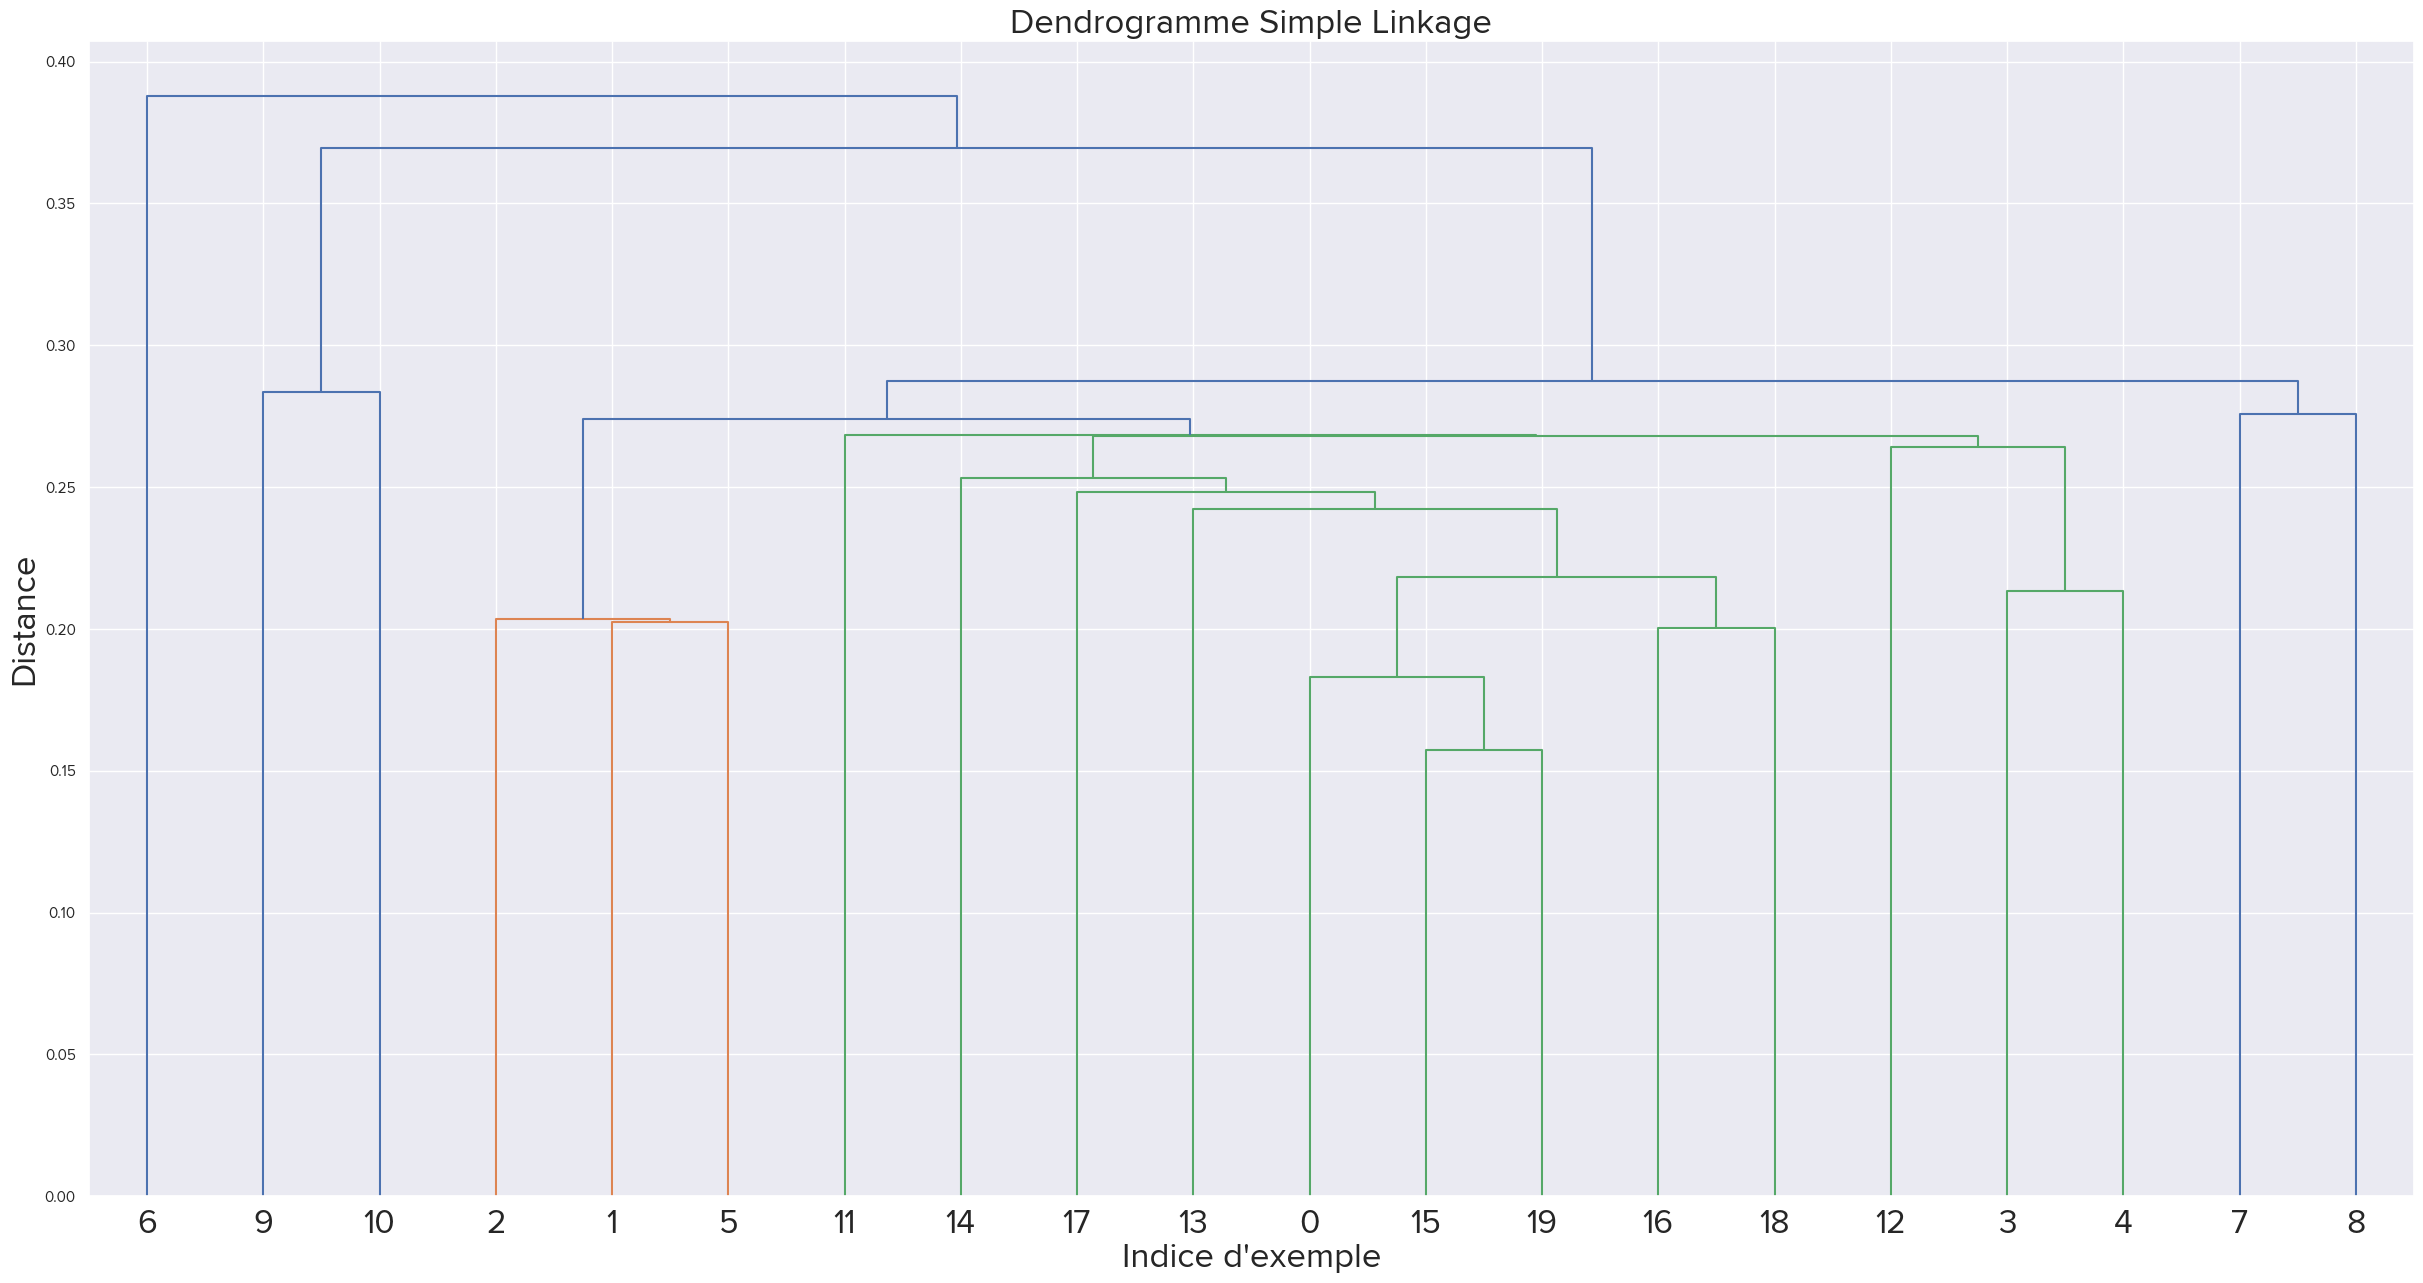

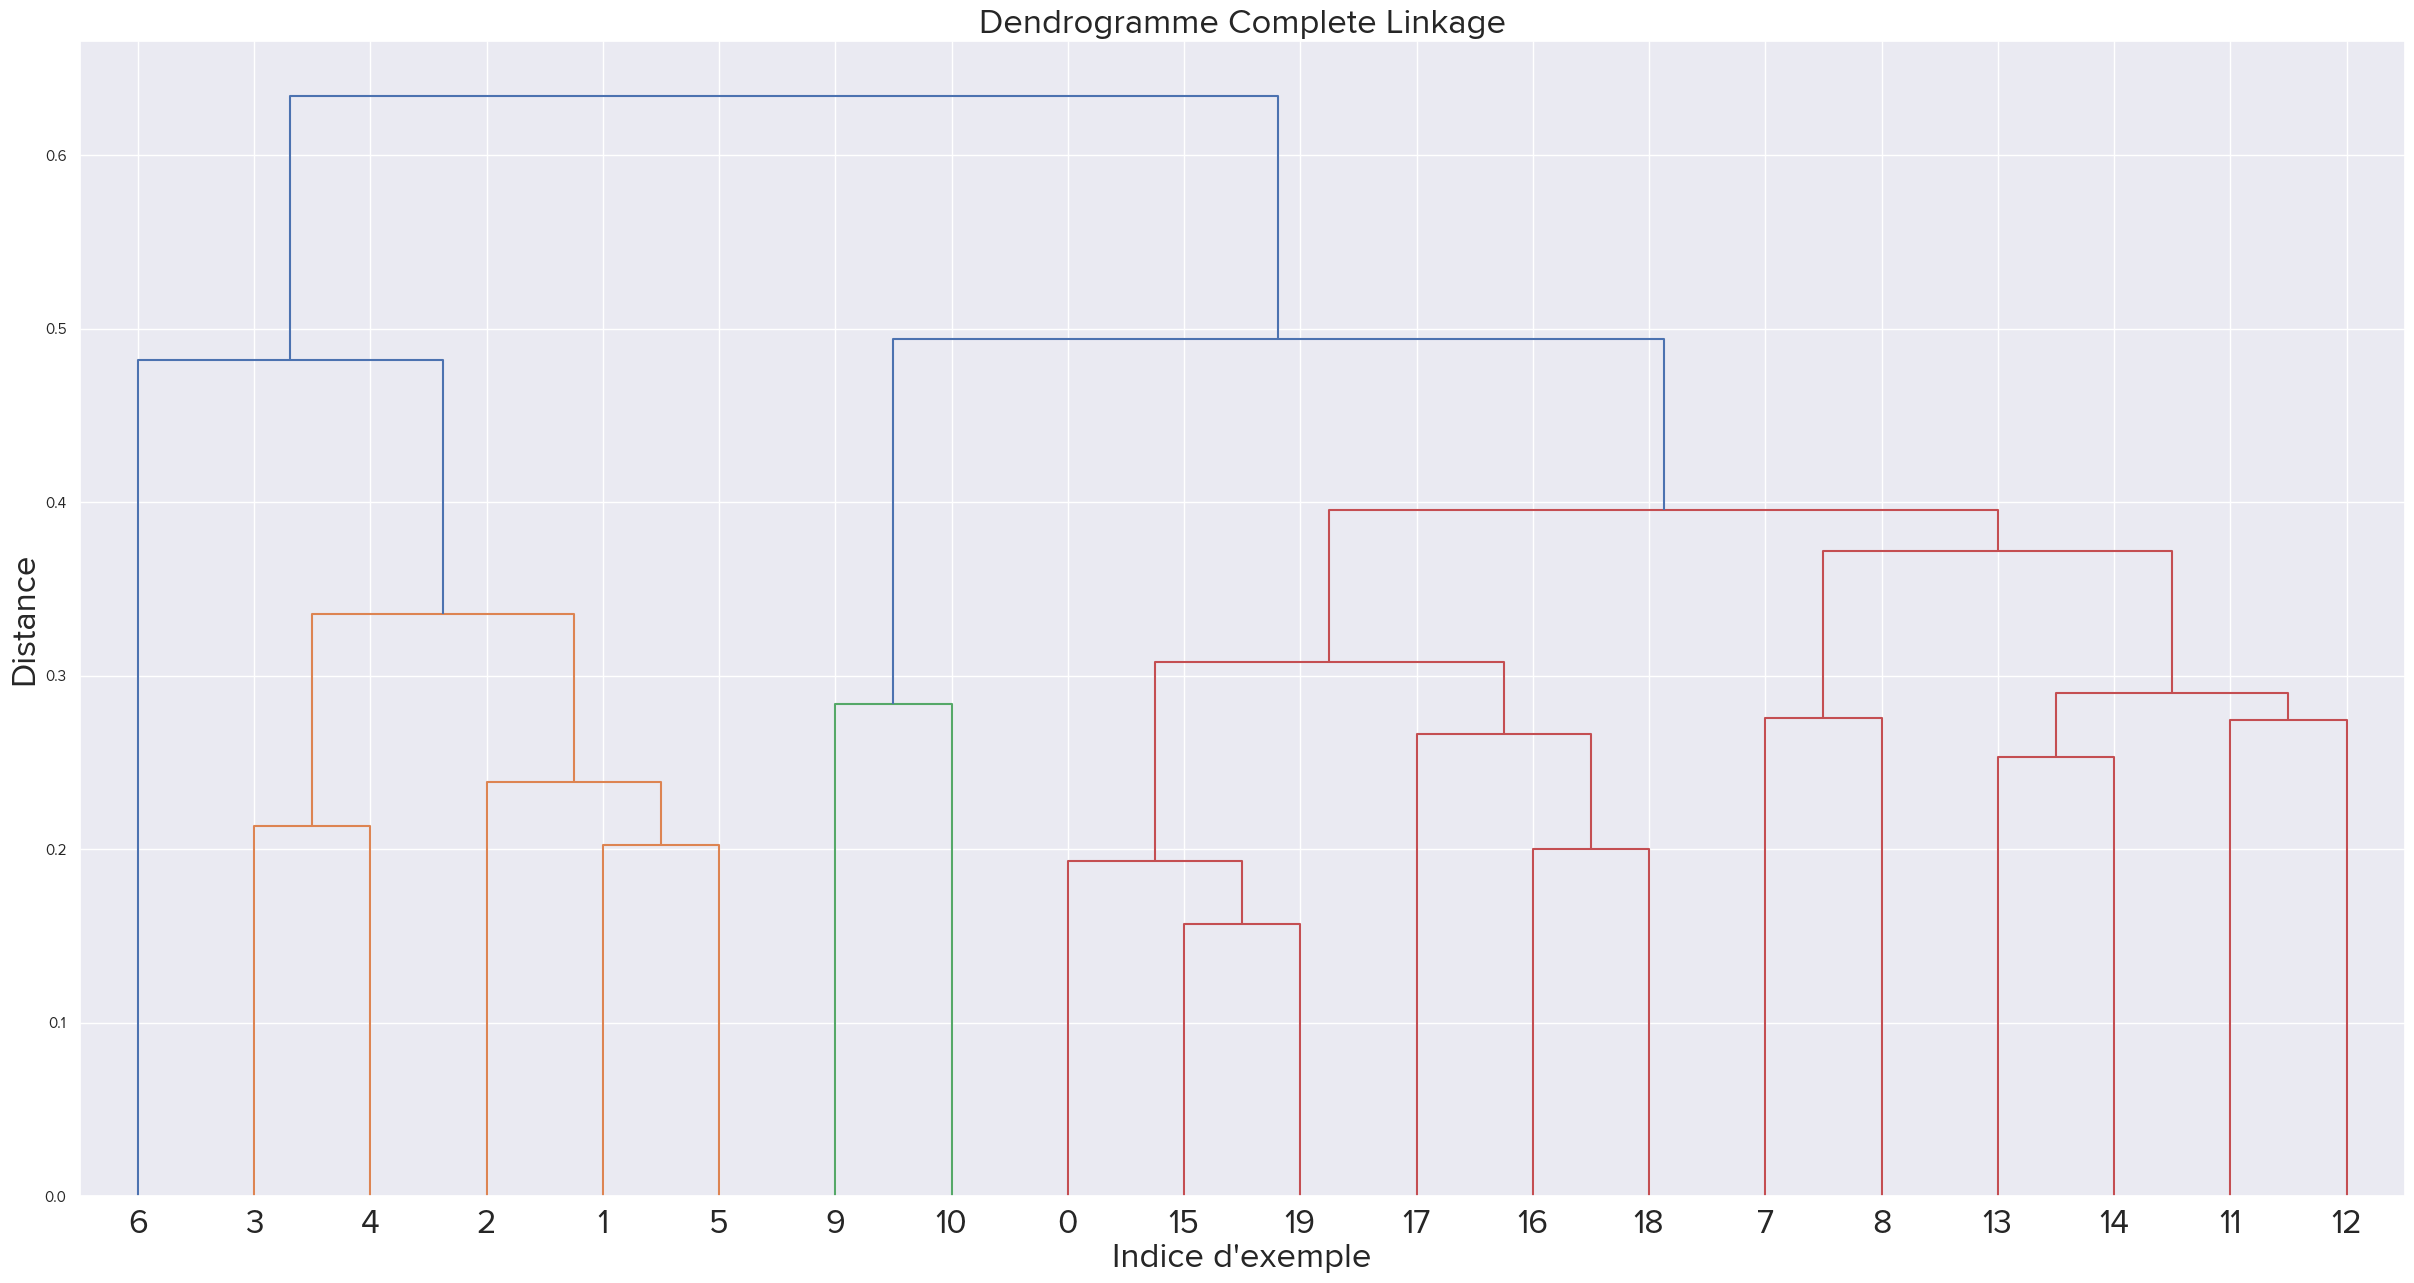

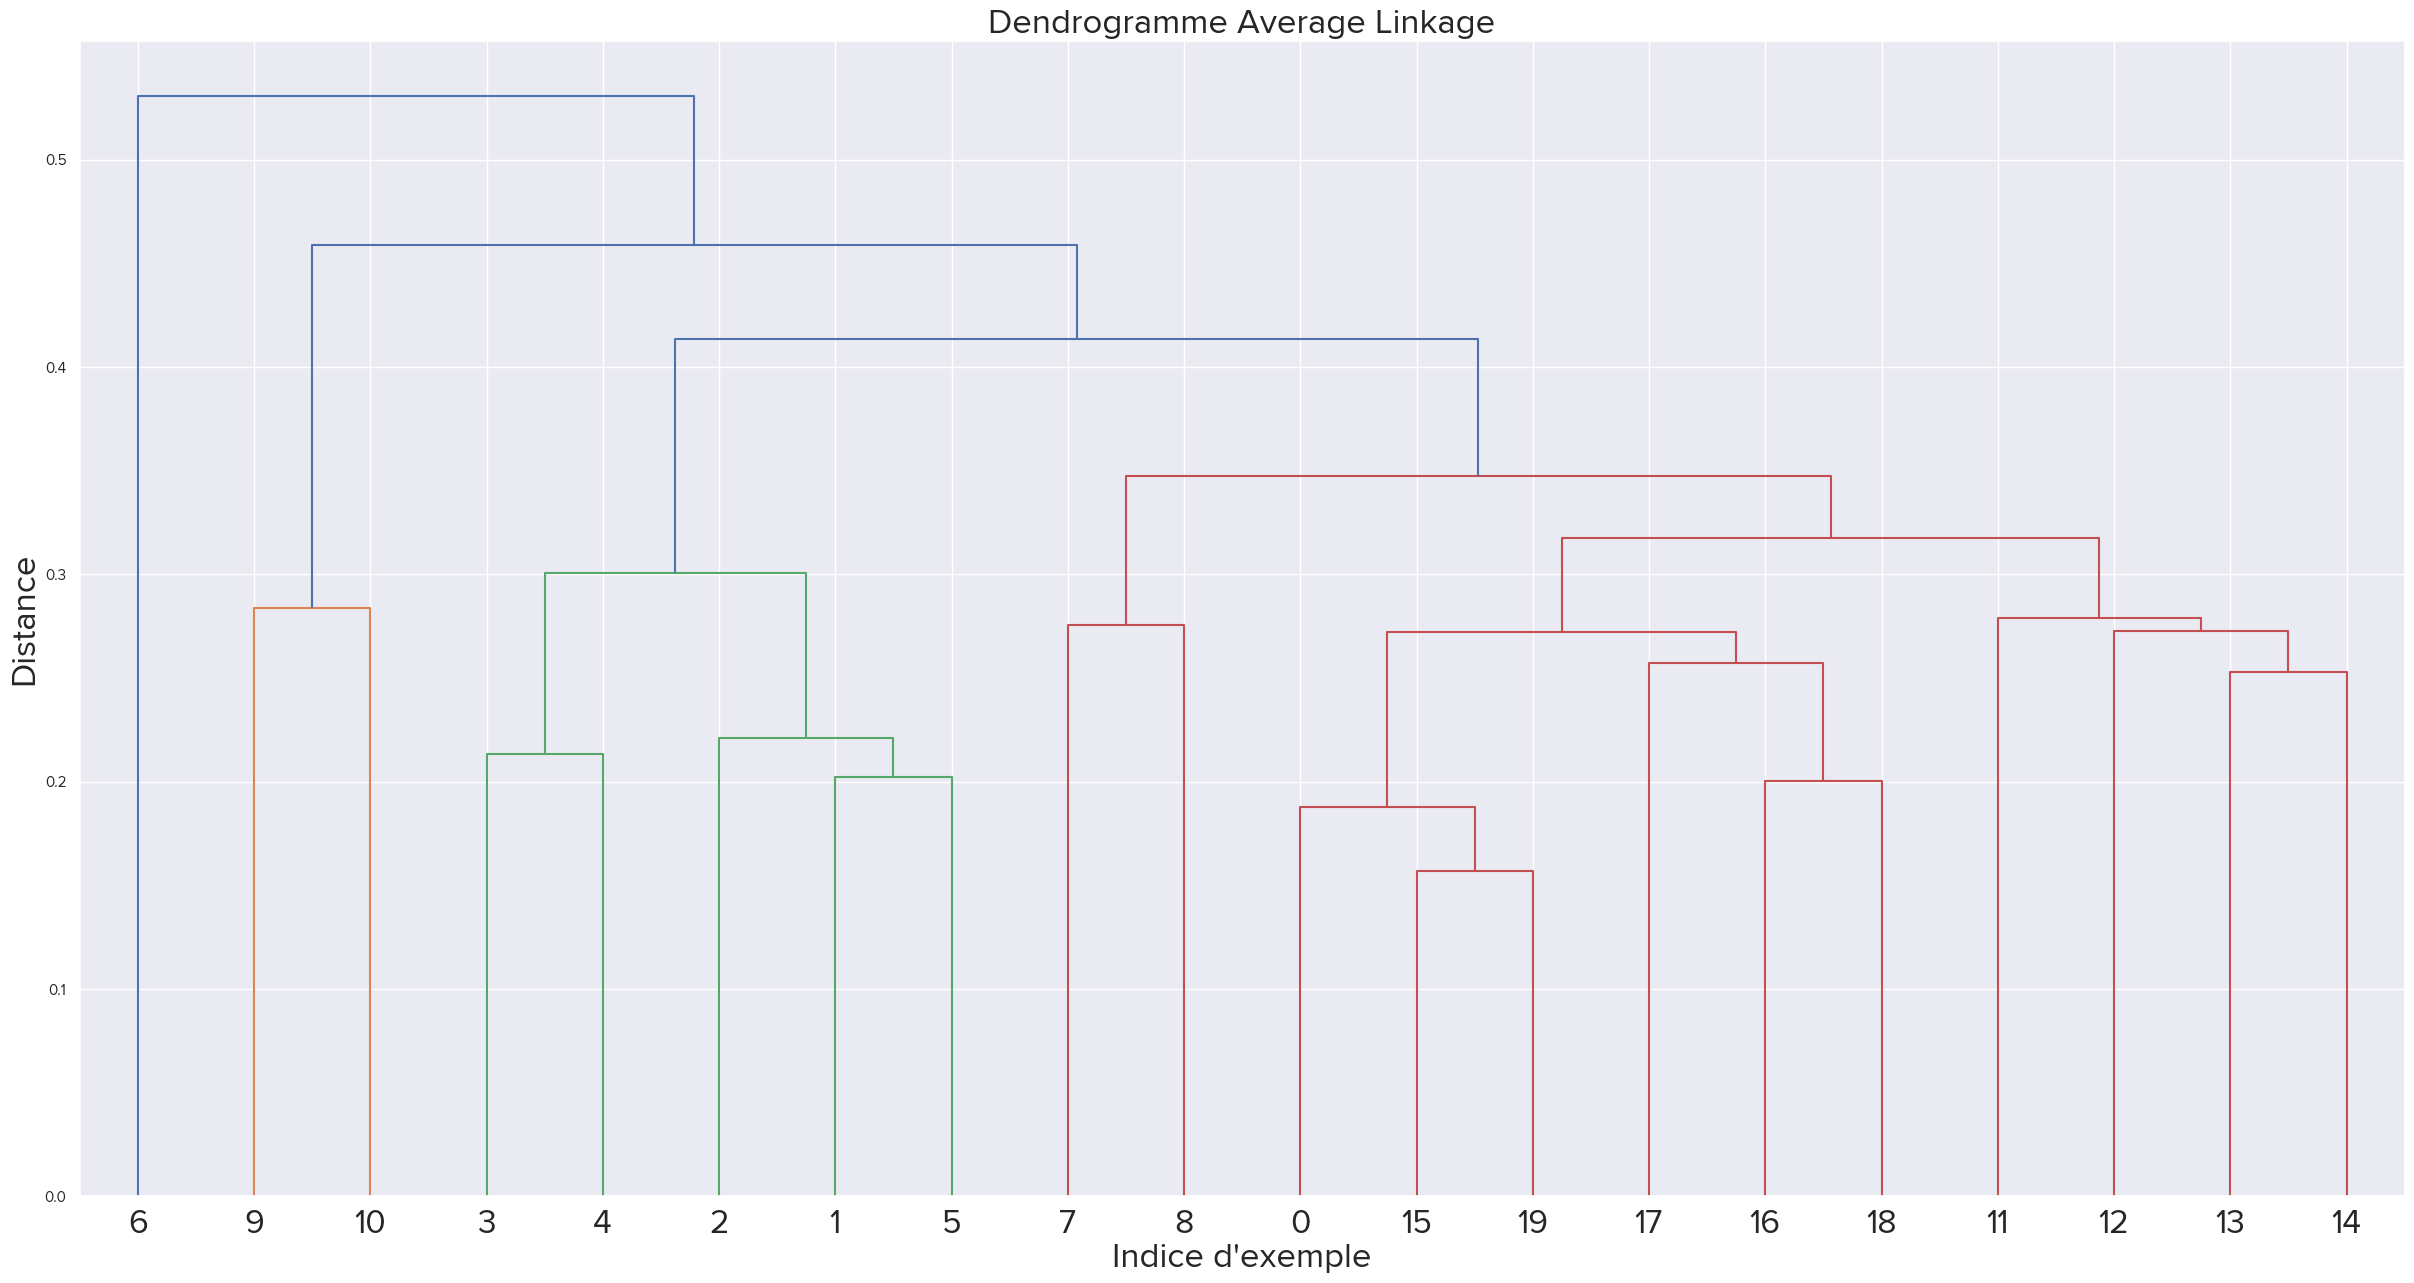

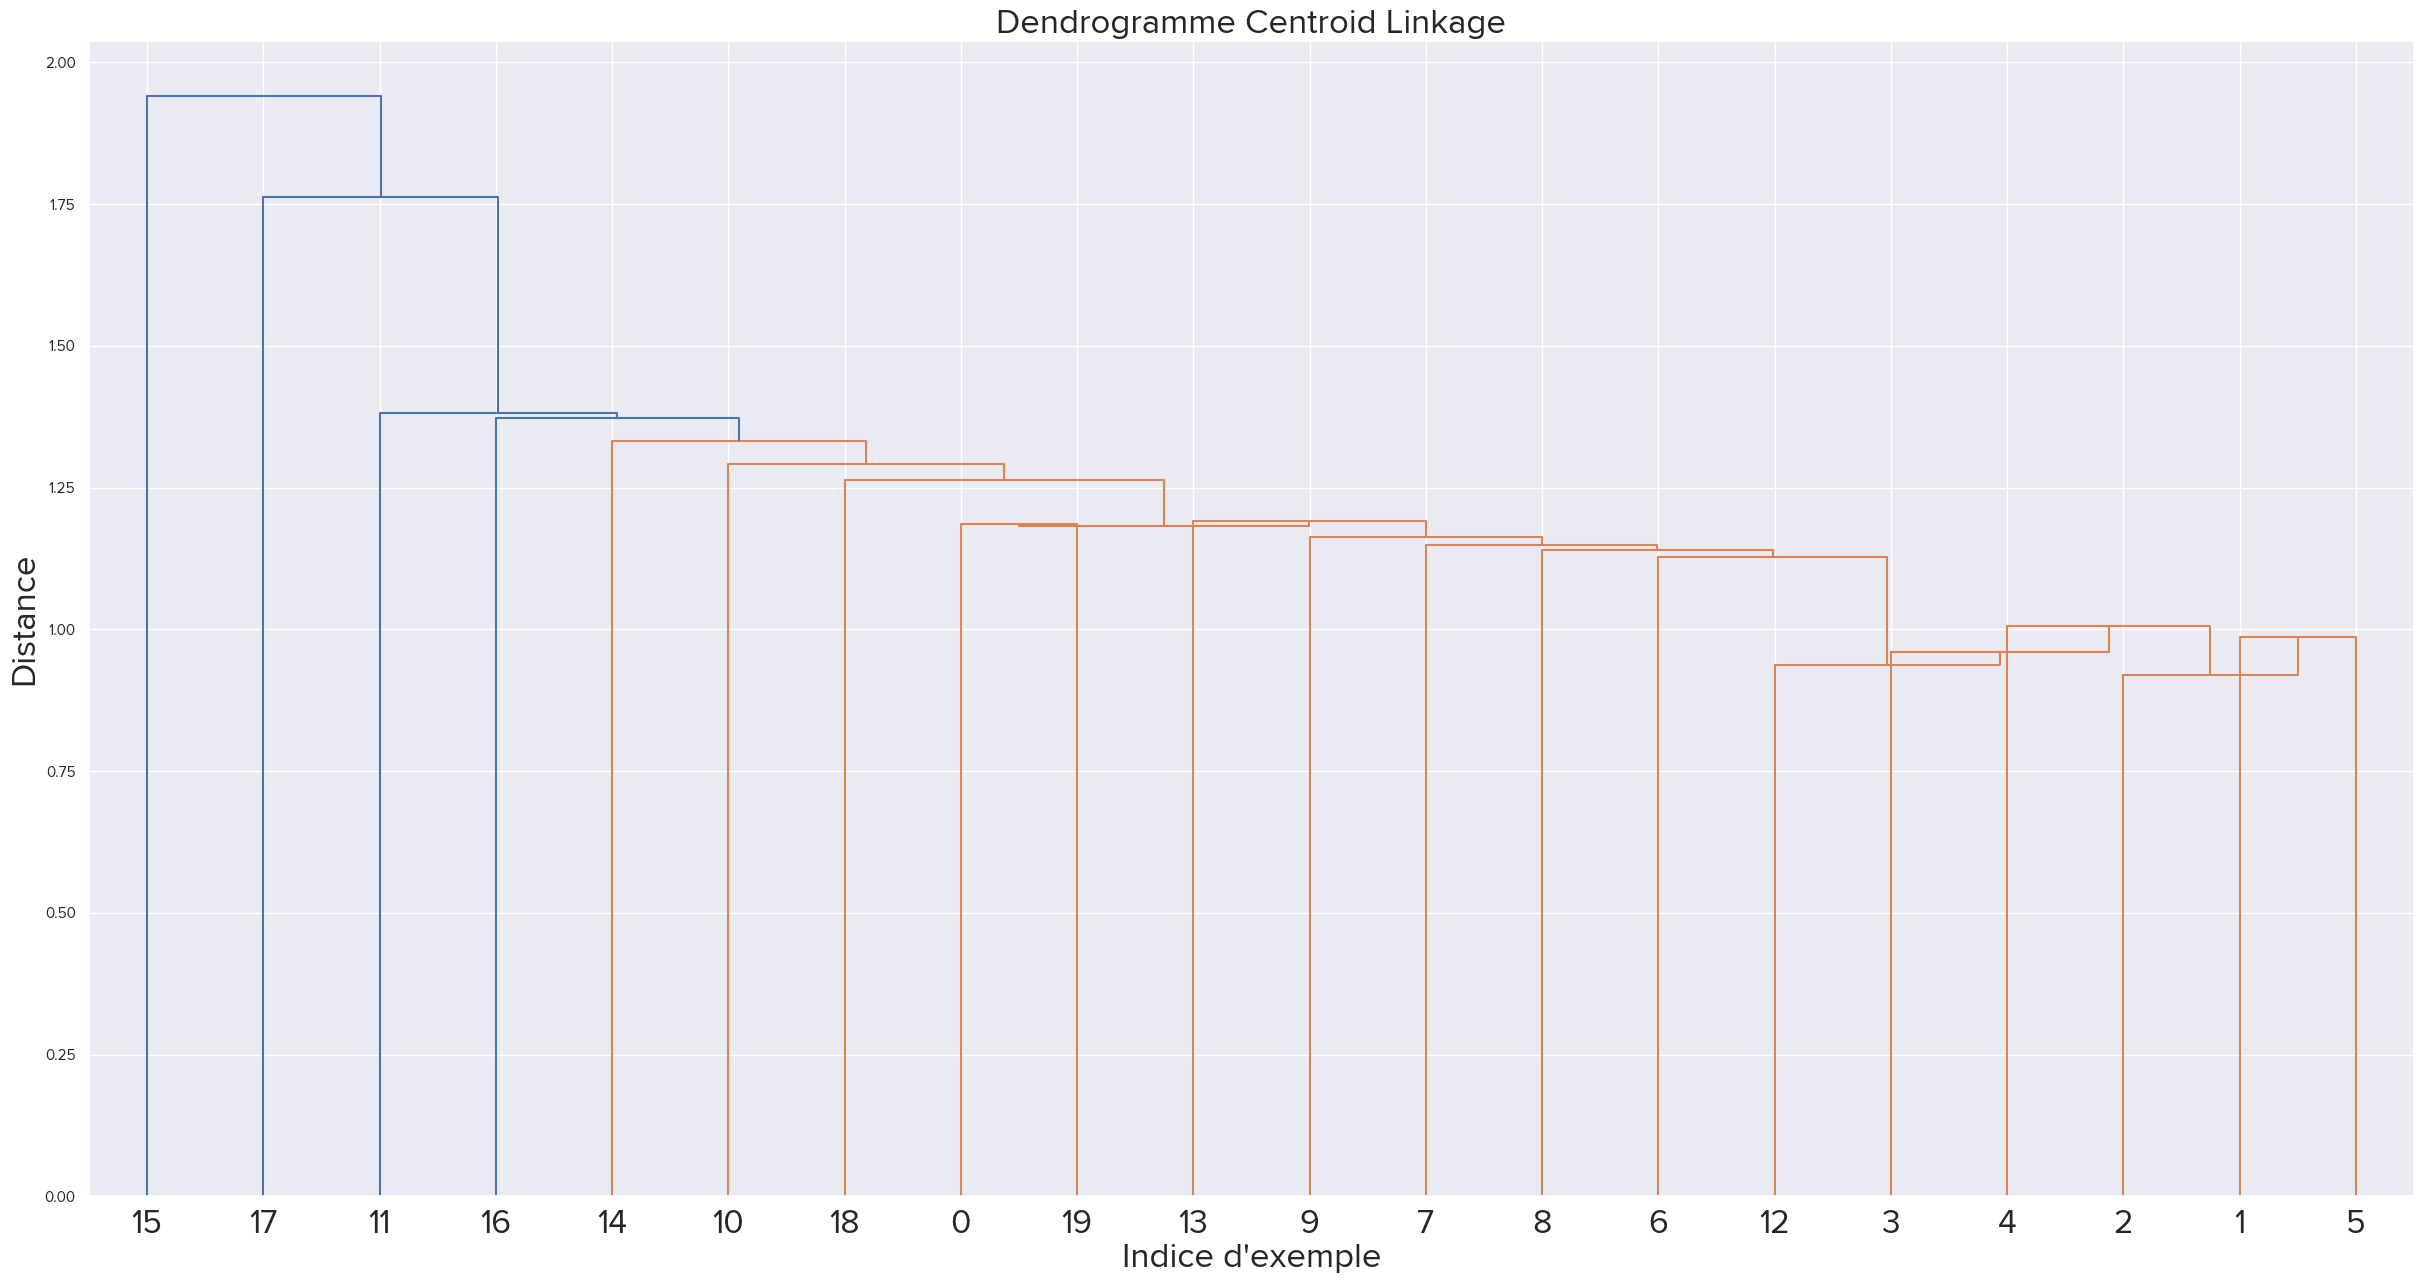

In [209]:
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=True)
targets_vectors = pd.DataFrame(ce.get_target_vectors(news_desc, news_no_stopwords))

methods = {'single':clust.CHA_simple,
           'complete':clust.CHA_complete,
           'average':clust.CHA_average,
            'centroid':clust.CHA_centroid}


for i, method in enumerate(methods):
    if method == "centroid":
        clust.CHA_centroid(targets_vectors, clust.dist_euclidienne, False, True)
    else:
        methods[method](targets_vectors, clust.dist_cosine, False, True)

`Targets` qui sont troujours groupés en 1ème ou 2ème niveau de fusion (uniquement en regardant `complete`, `simple`, `average` car ils ont donné les résultats les plus intéressants)
- 3, 4 (comp.ibm.pc.hardware, comp.sys.mac.hardware)
- 16, 18 (talk.politics.misc, talk.politics.misc)
- 1, 2, 5 (comp.graphics, comp.os.ms-windows.misc, comp.windows.x)
- 7, 8 (rec.autos, rec.motorcycles)
- 9, 10 (rec.sport.baseball, rec.sport.hockey)
- 0, 15, 19 (alt.atheism, soc.religion.christian, talk.religion.misc)

**Remarque** : `target 6` est très loin de tout les autres targets. Dans les autres vectorisation `target 6` est groupé avec les `targets 3, 4`

### Bag-of-Words non binaire

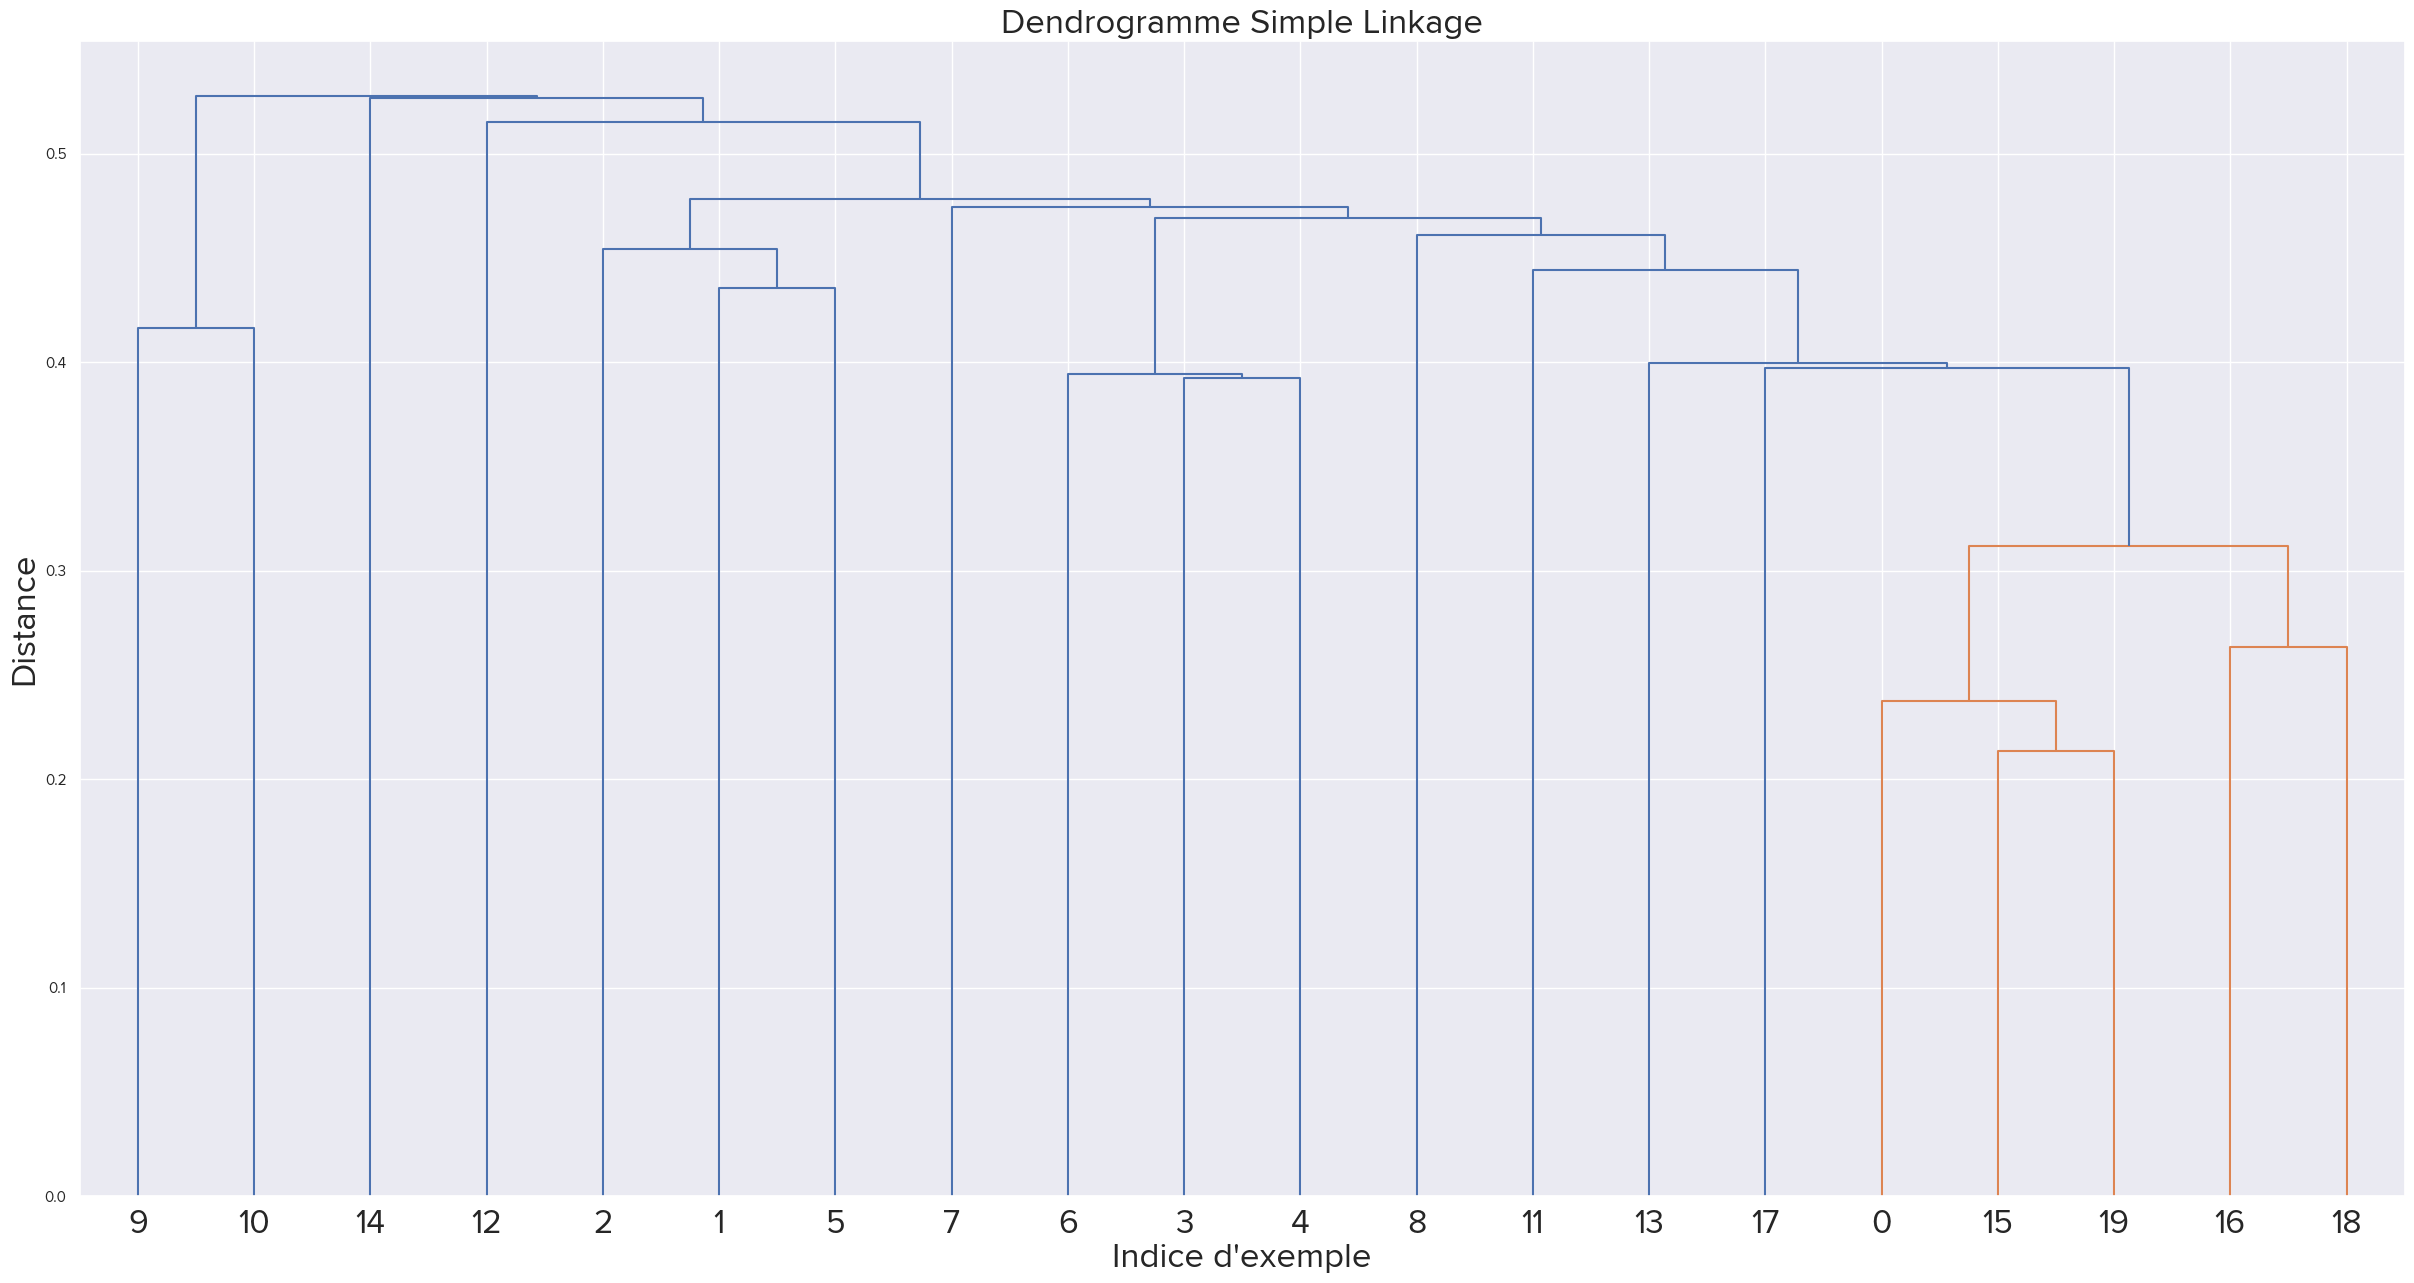

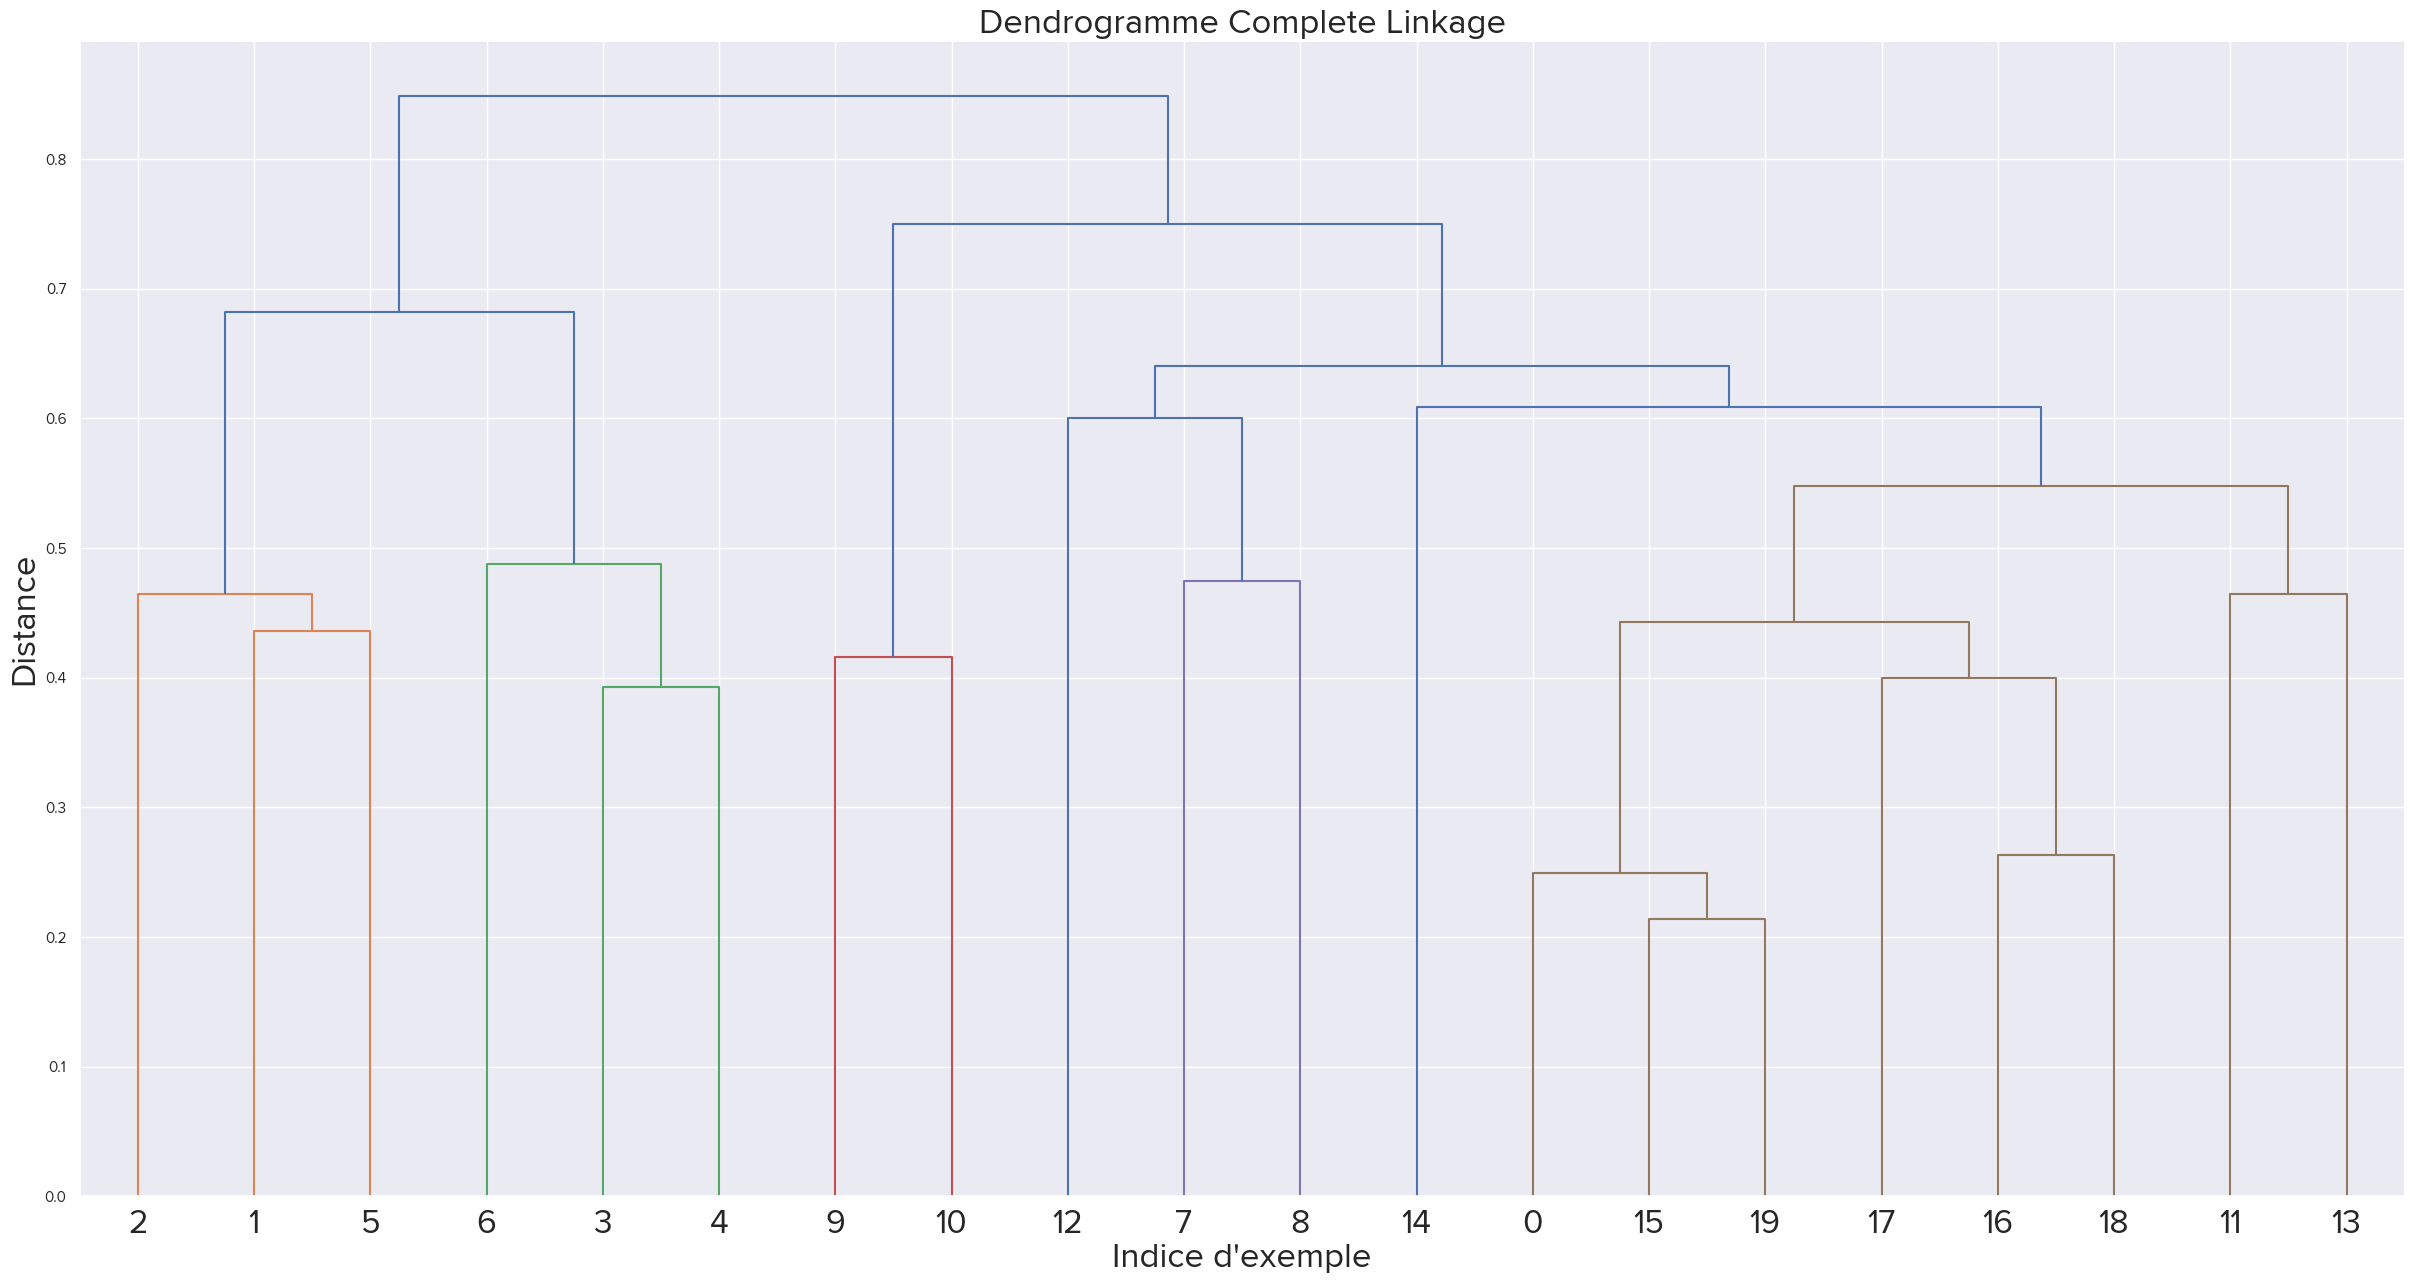

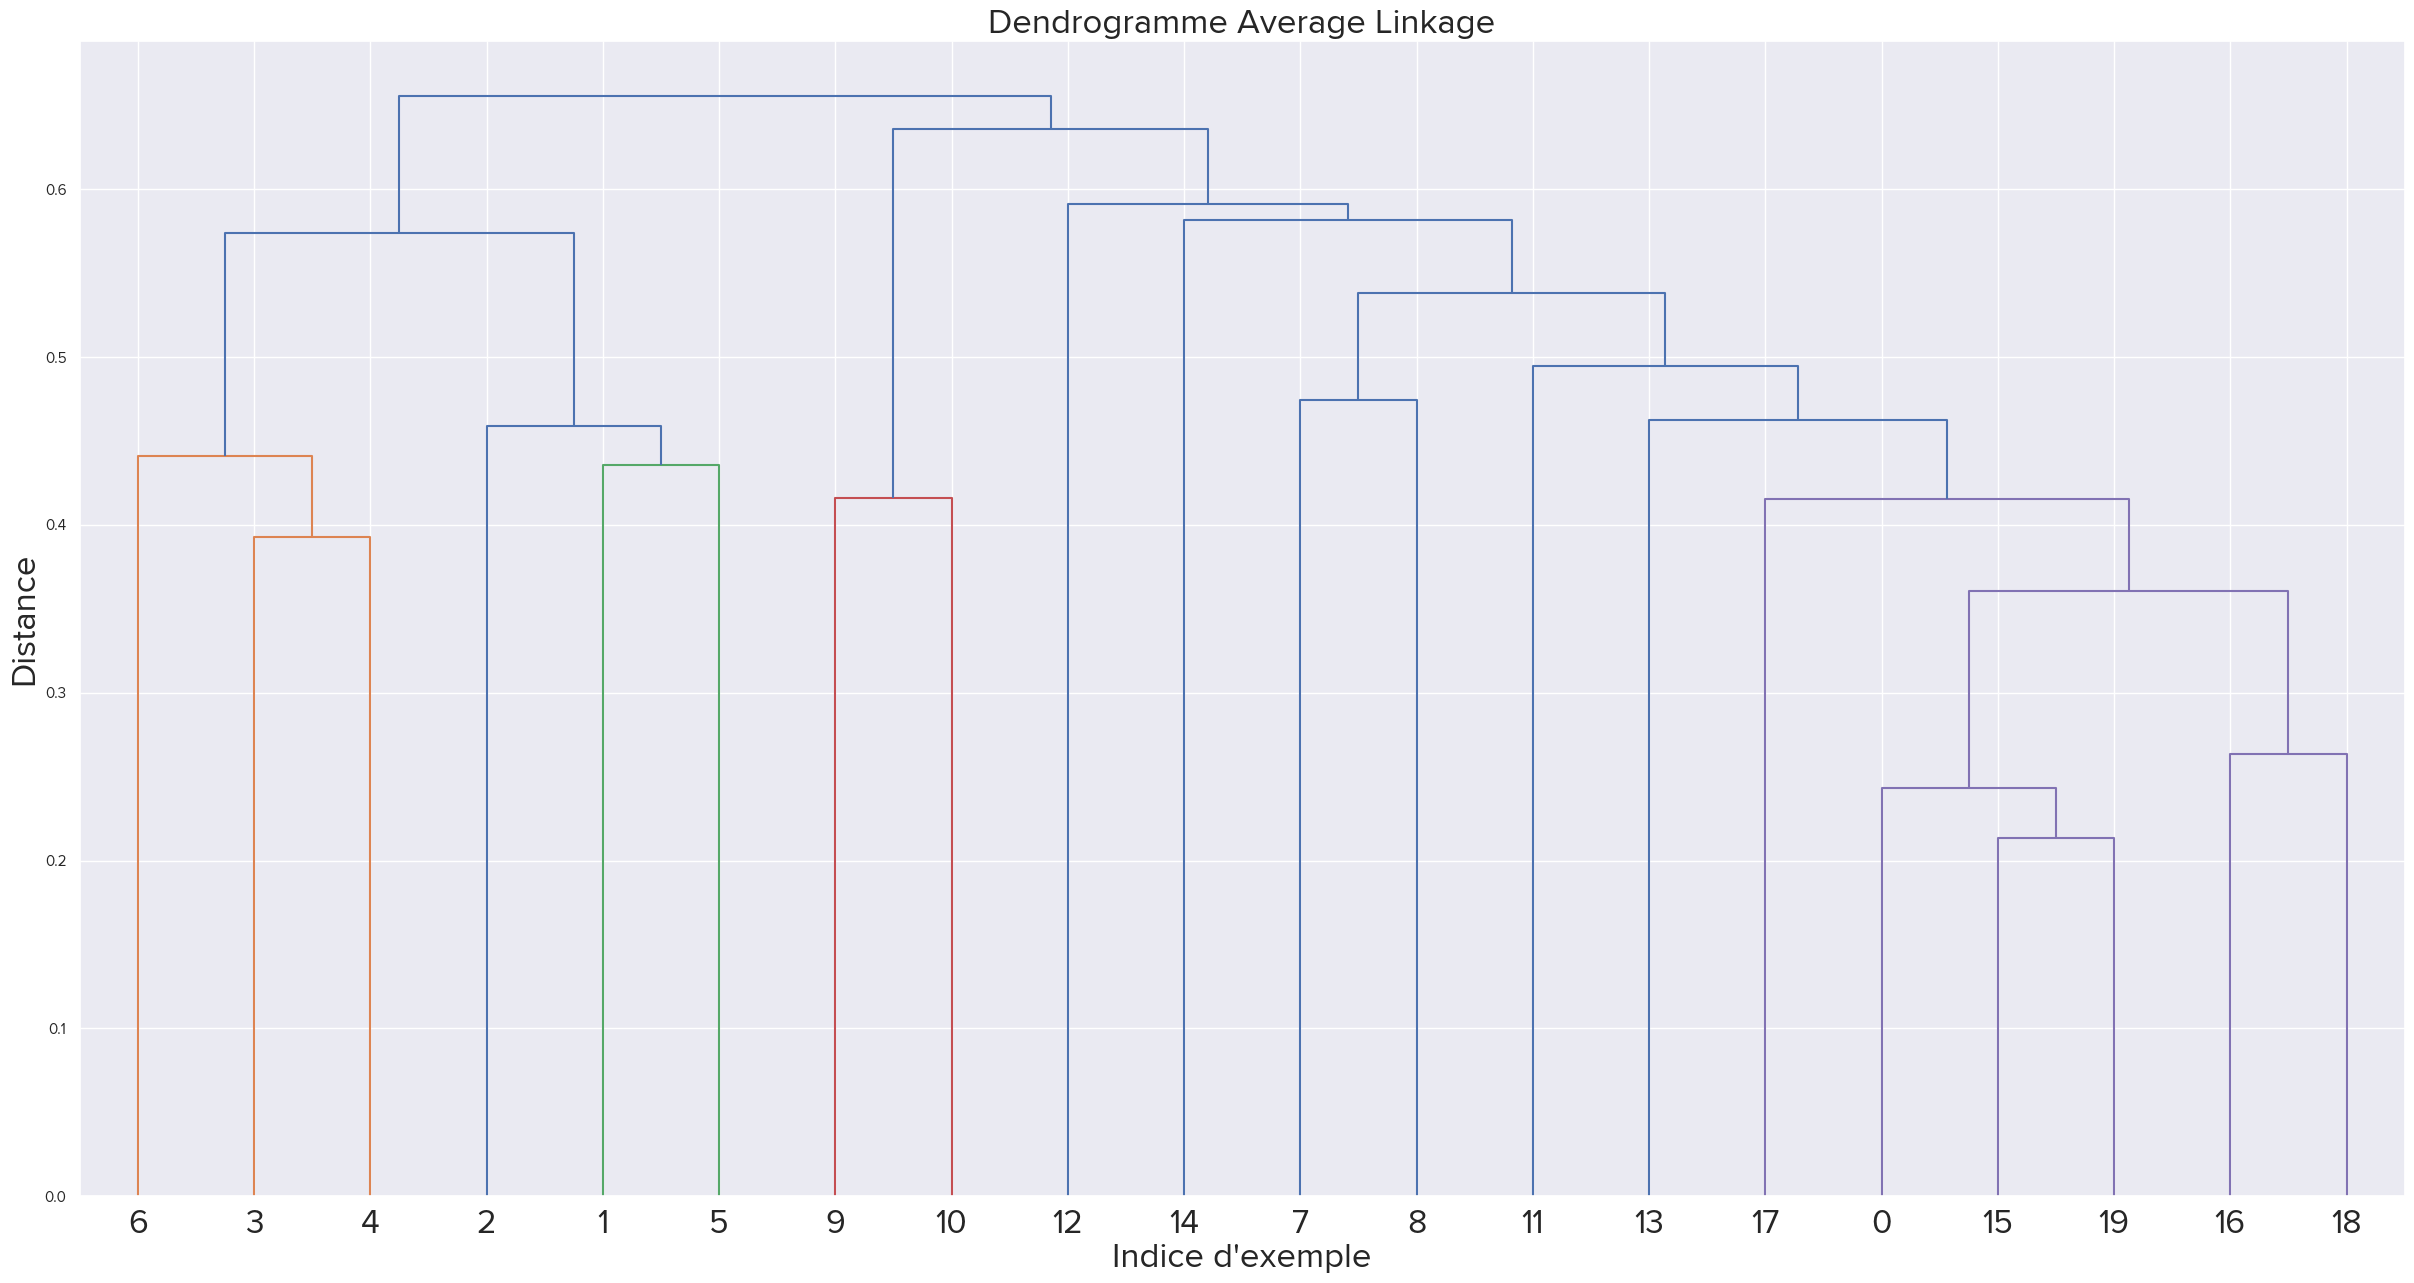

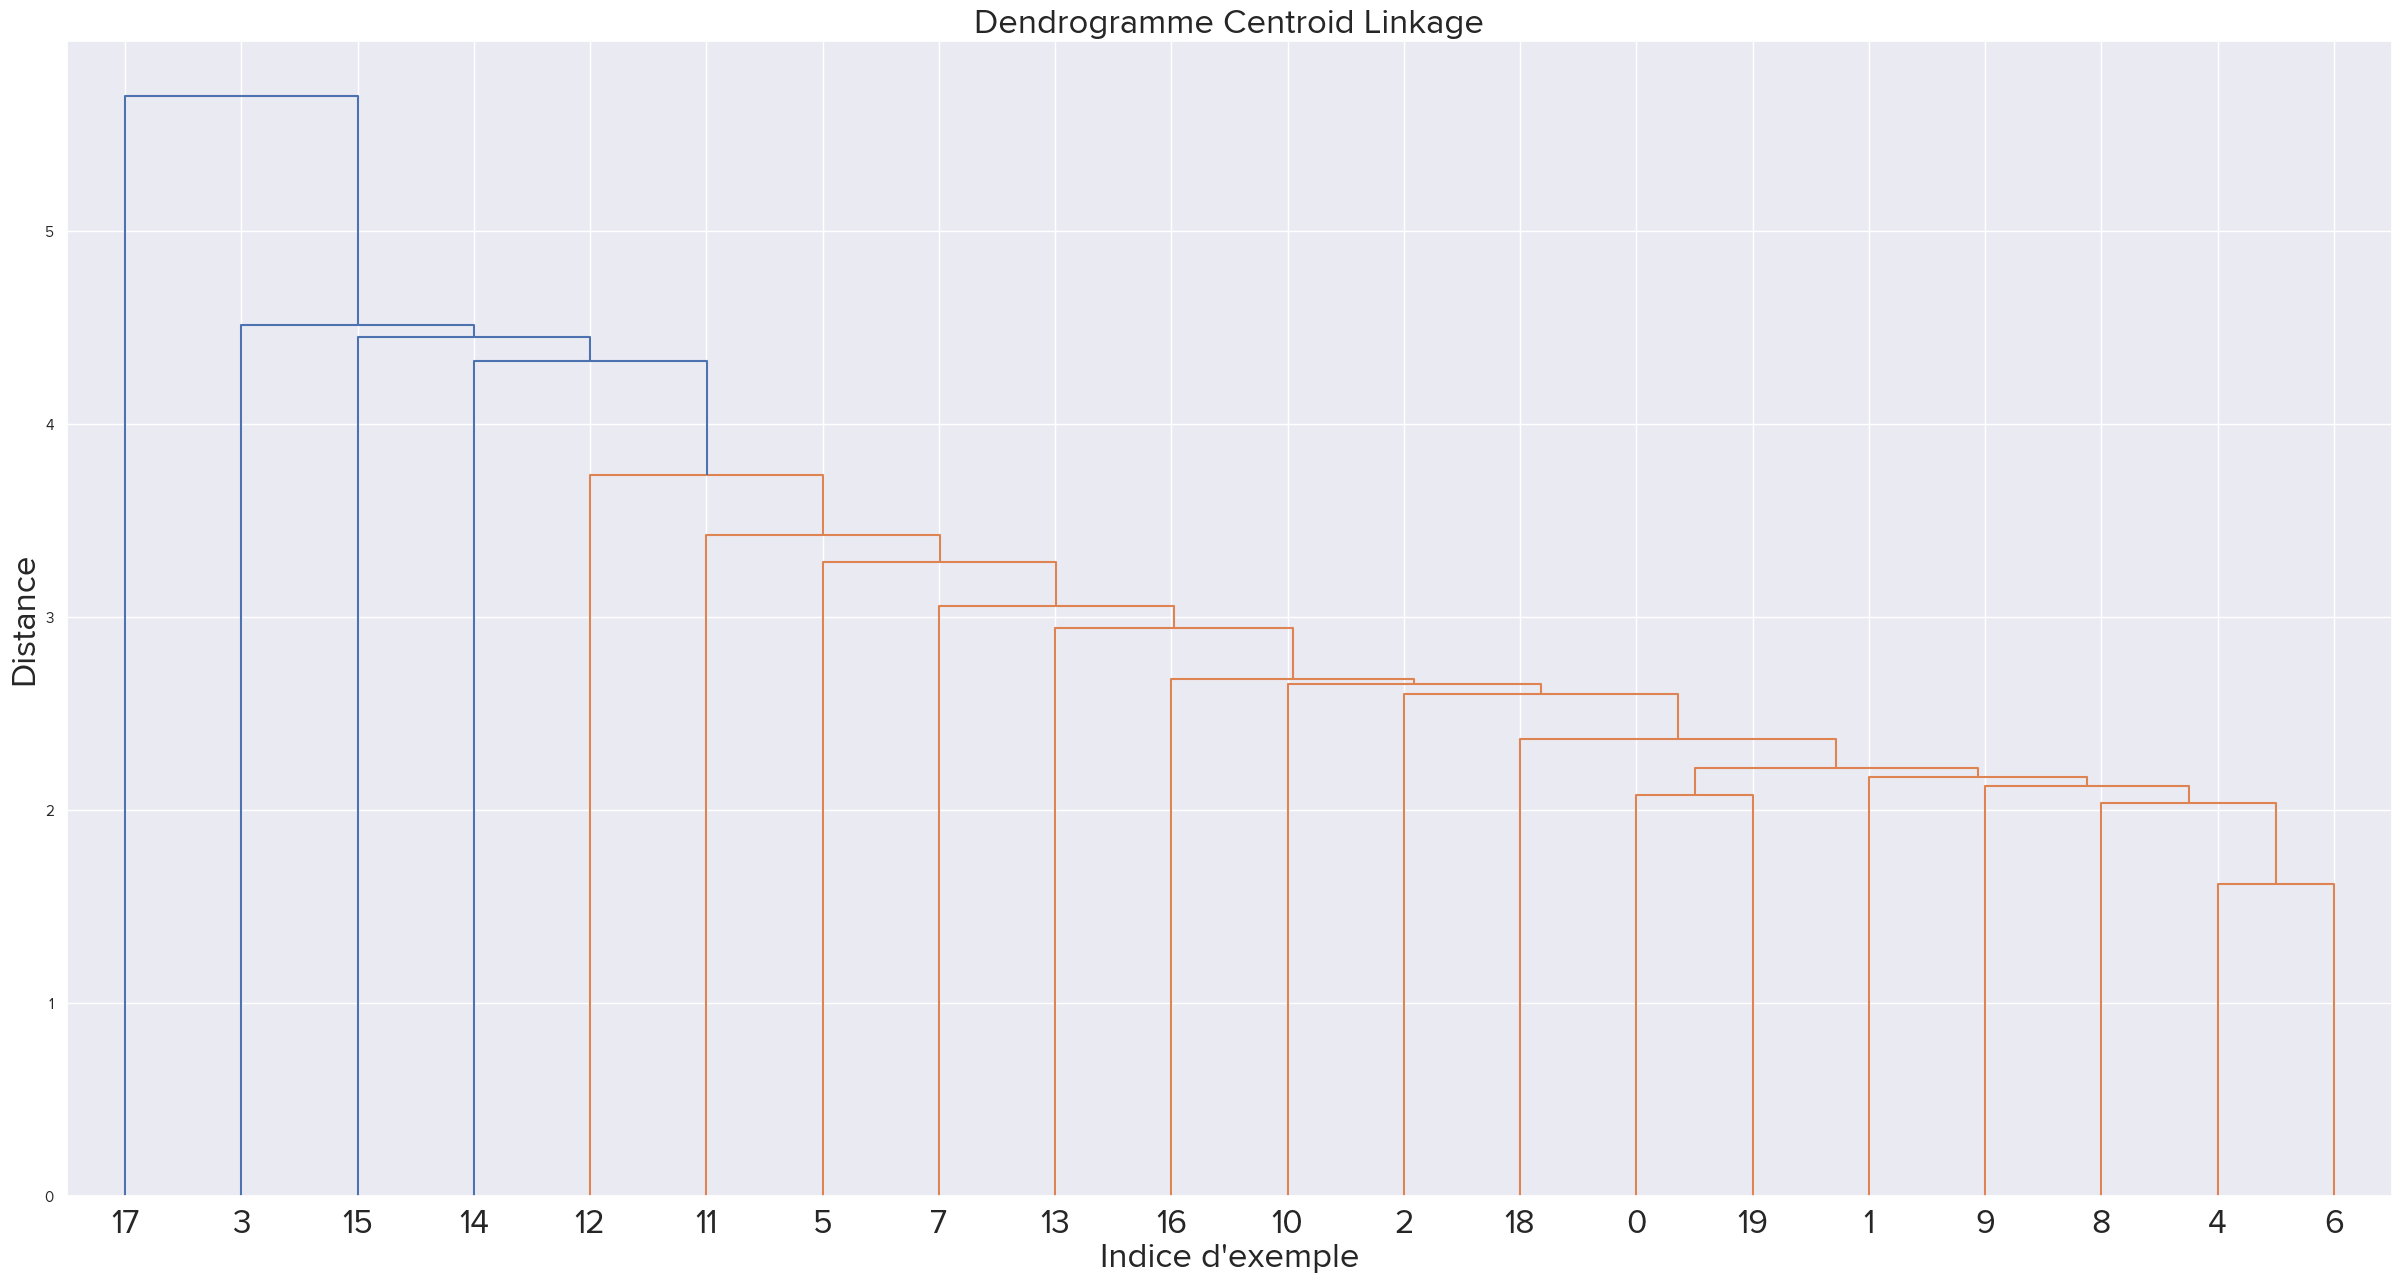

In [210]:
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=False)
targets_vectors = pd.DataFrame(ce.get_target_vectors(news_desc, news_no_stopwords))

methods = {'single':clust.CHA_simple,
           'complete':clust.CHA_complete,
           'average':clust.CHA_average,
            'centroid':clust.CHA_centroid}


for i, method in enumerate(methods):
    if method == "centroid":
        clust.CHA_centroid(targets_vectors, clust.dist_euclidienne, False, True)
    else:
        methods[method](targets_vectors, clust.dist_cosine, False, True)

`Targets` qui sont troujours groupés en 1ème ou 2ème niveau de fusion (uniquement en regardant `complete`, `simple`, `average` car ils ont donné les résultats les plus intéressants)
- 1, 2, 5 (comp.graphics, comp.os.ms-windows.misc, comp.windows.x)
- 3, 4, 6 (comp.ibm.pc.hardware, comp.sys.mac.hardware, misc.forsale)
- 9, 10 (rec.sport.baseball, rec.sport.hockey)
- 0, 15, 19 (alt.atheism, soc.religion.christian, talk.religion.misc)
- 16, 18 (talk.politics.misc, talk.politics.misc)

### Tf-Idf

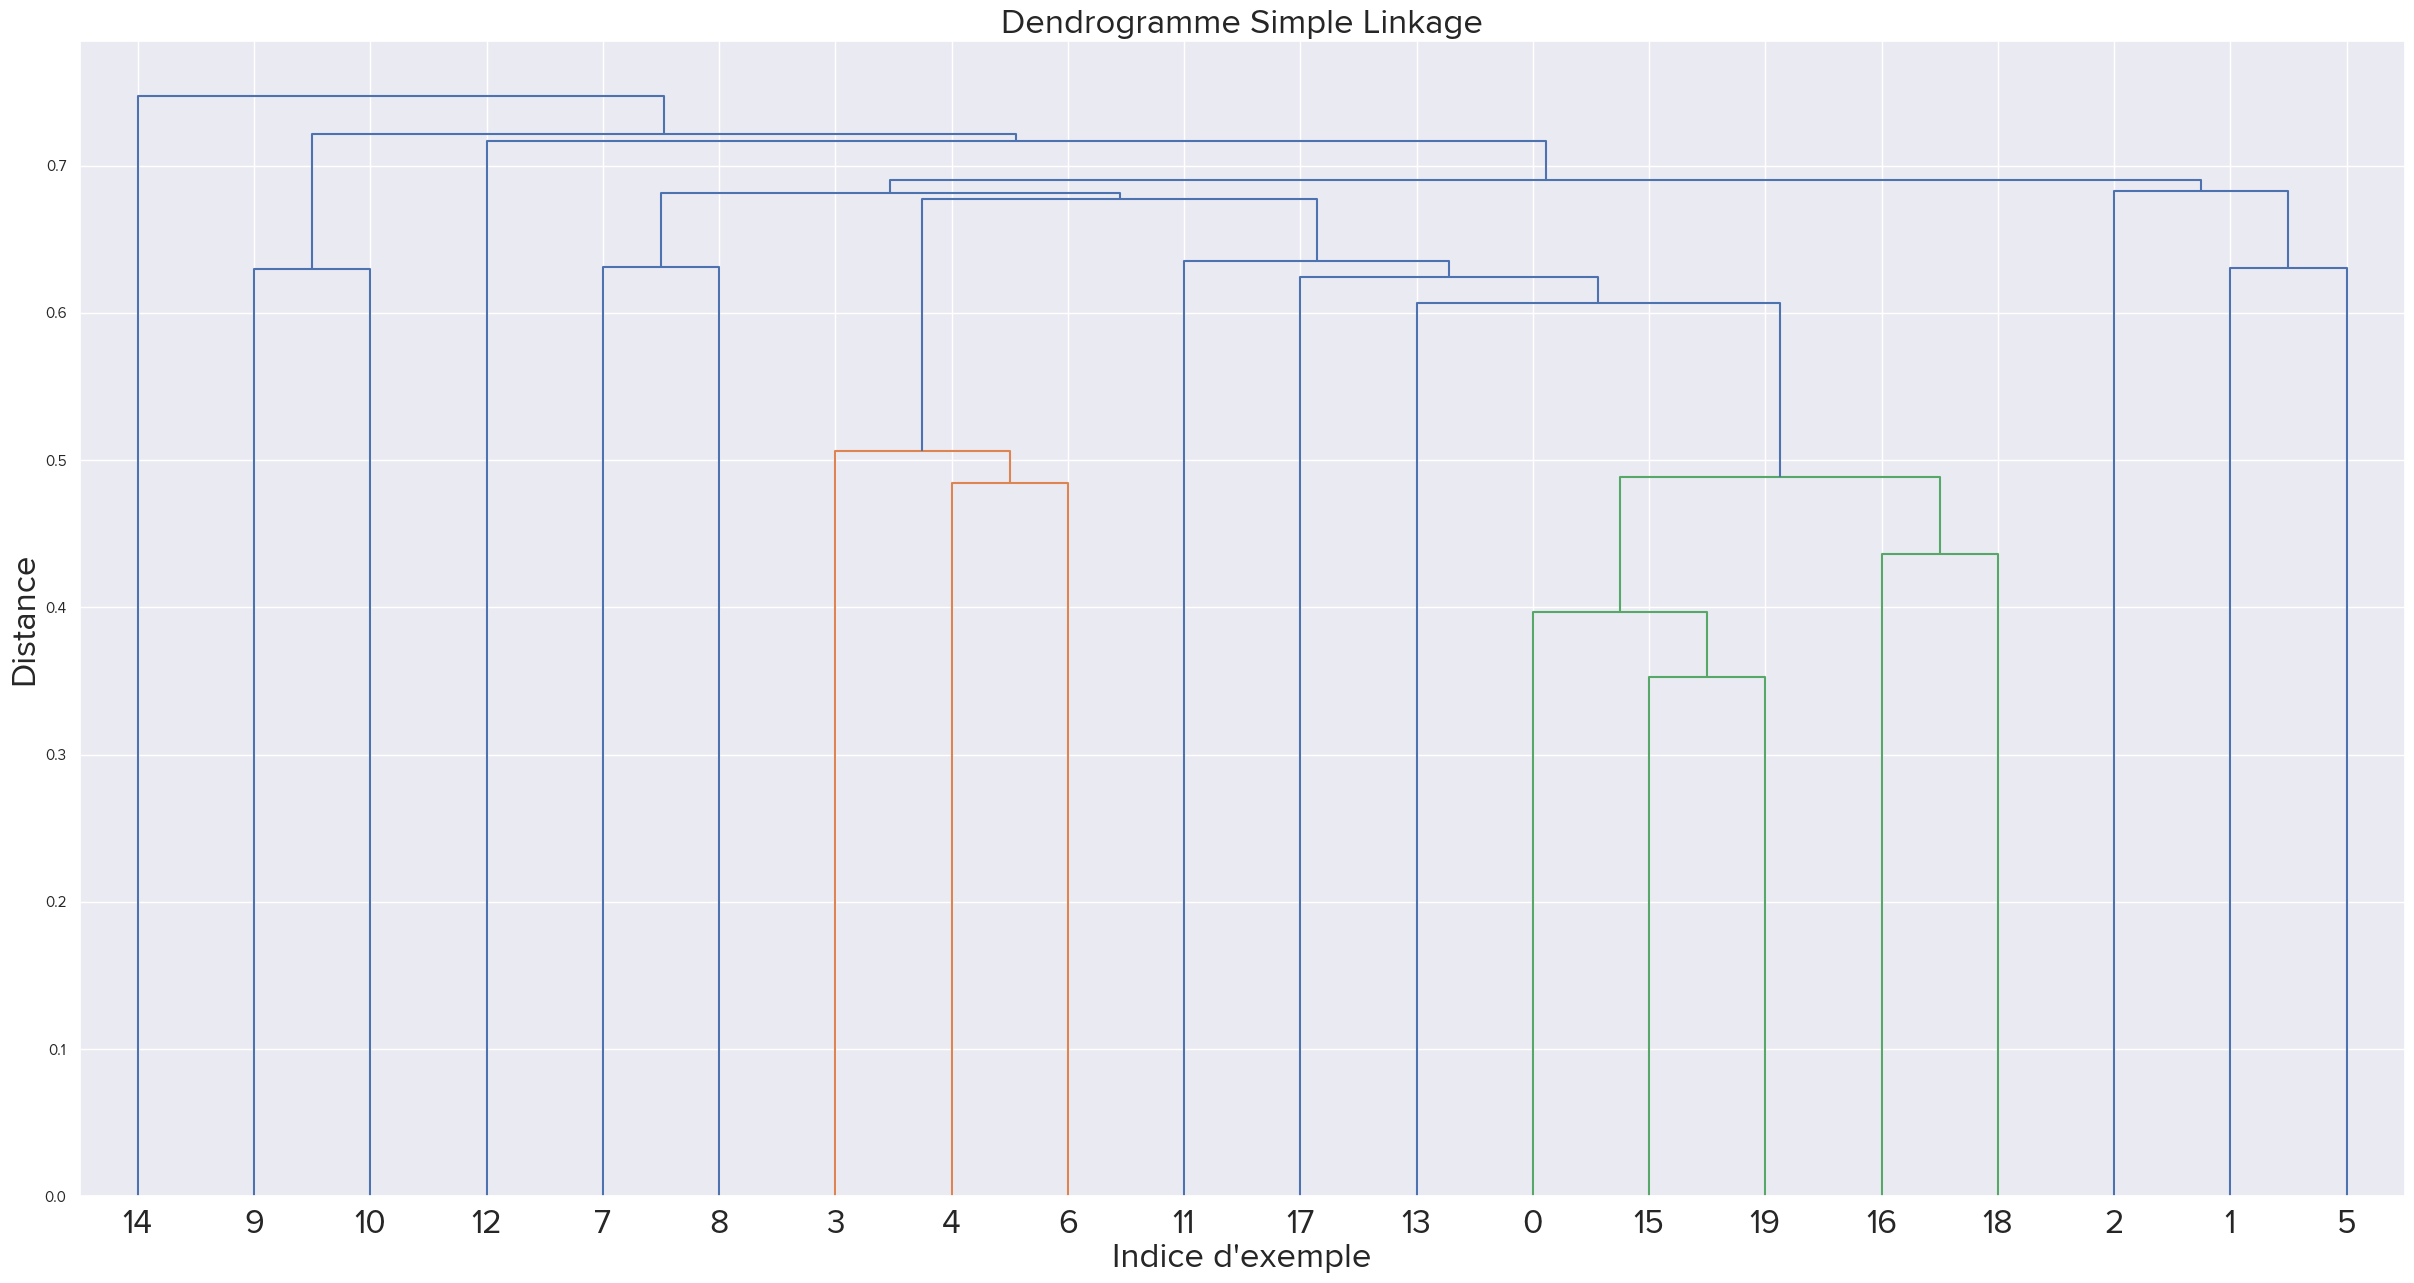

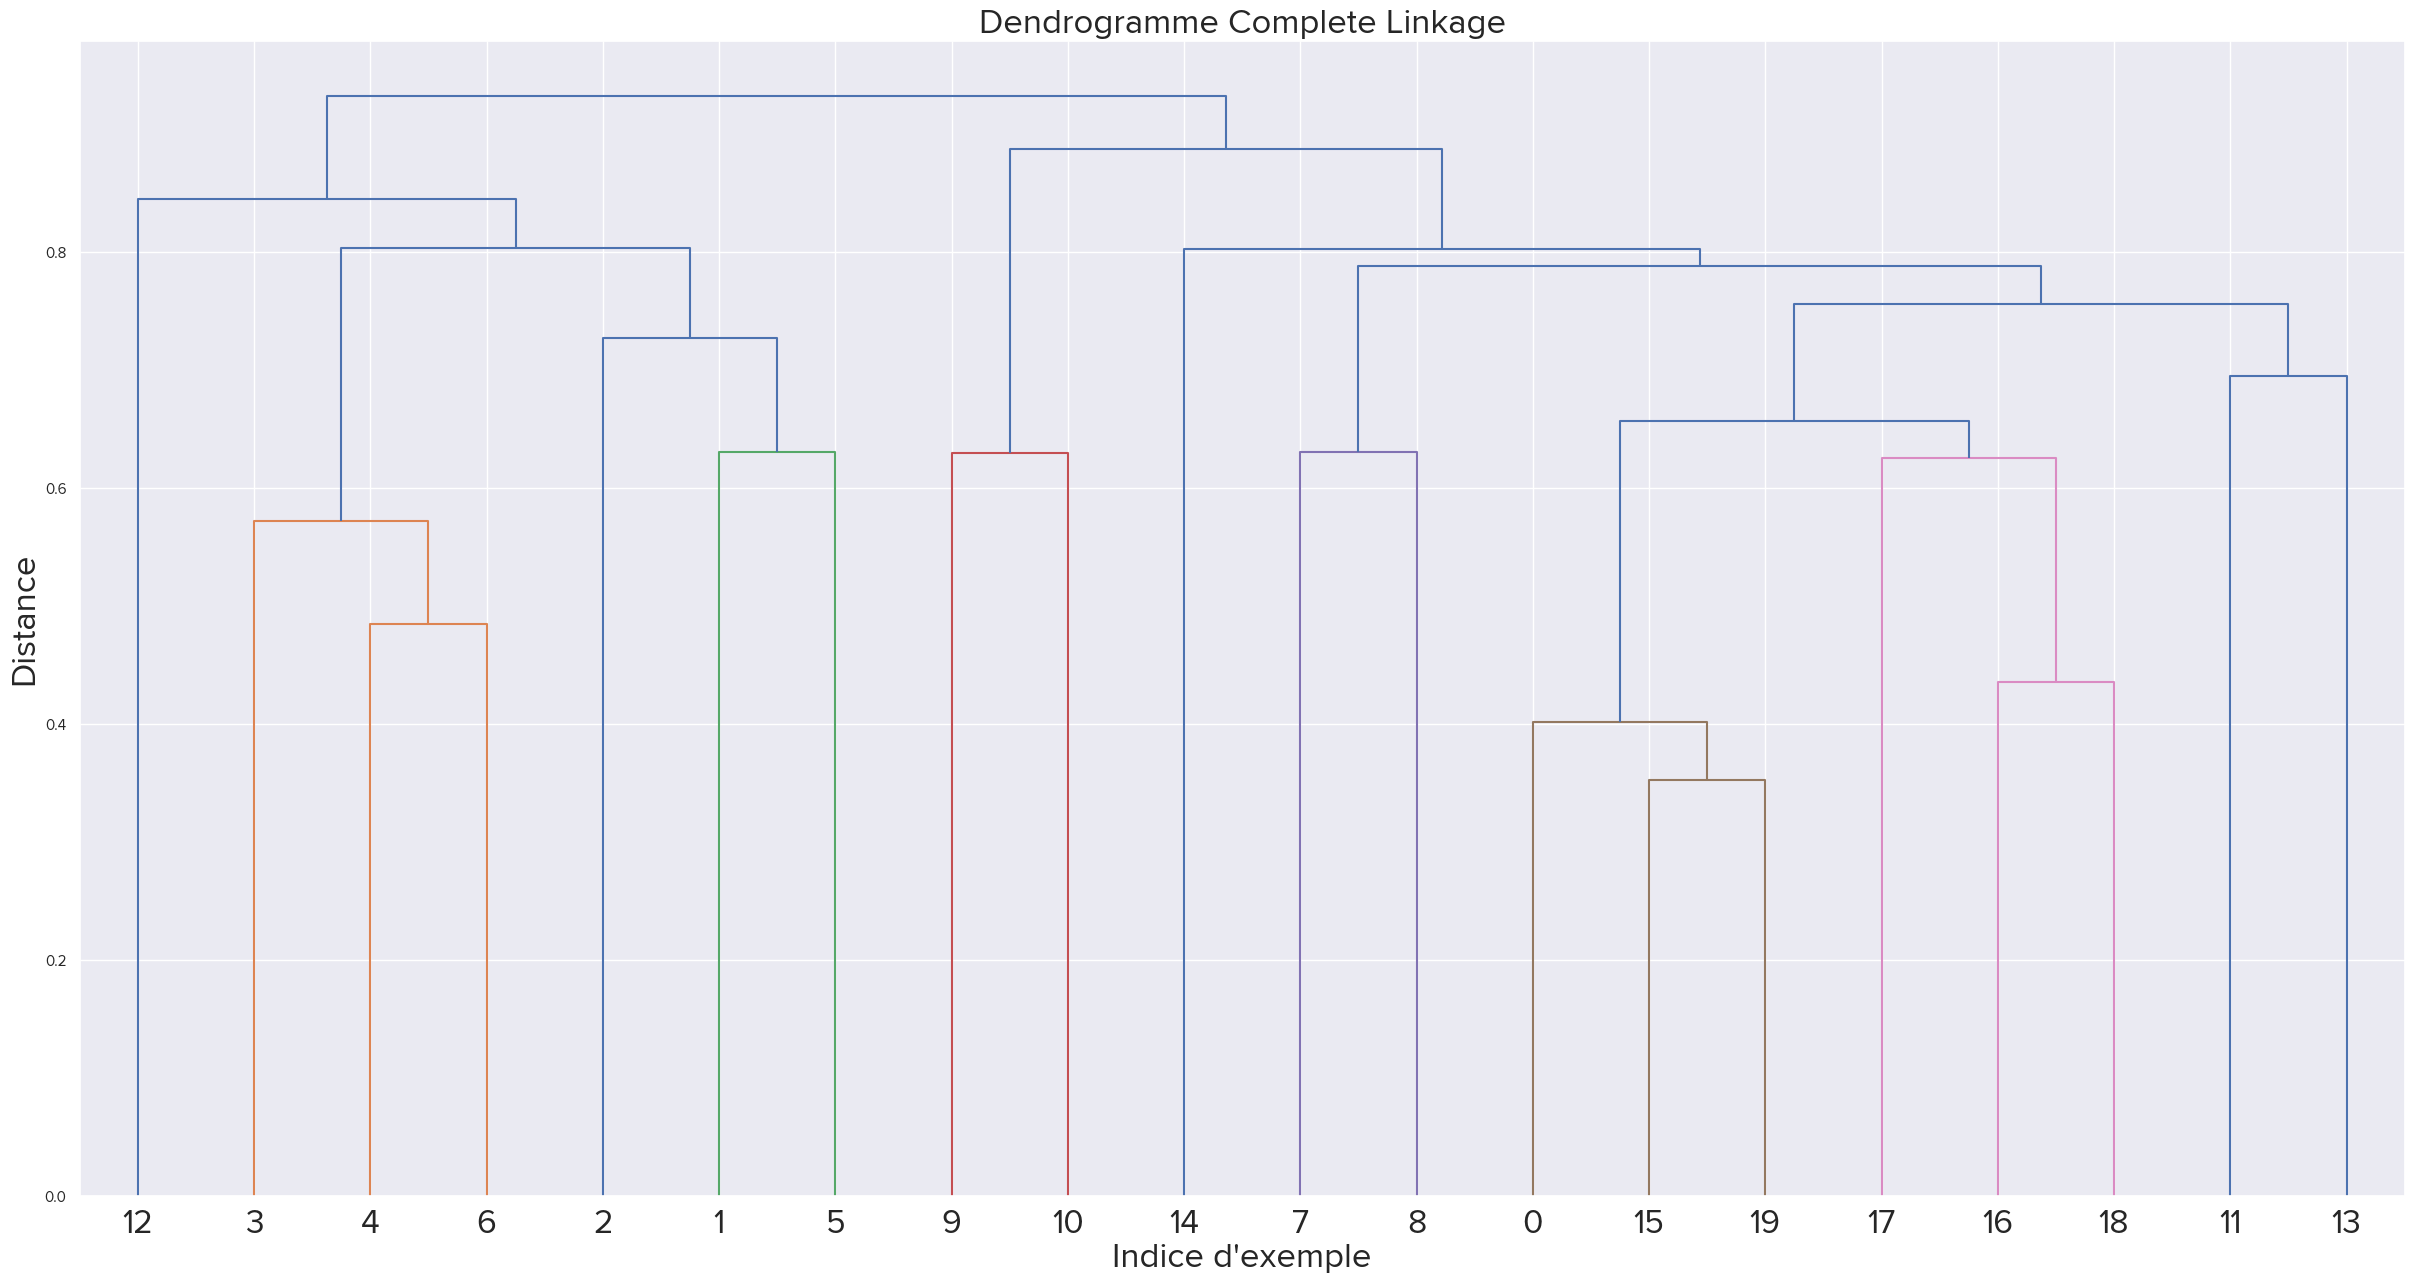

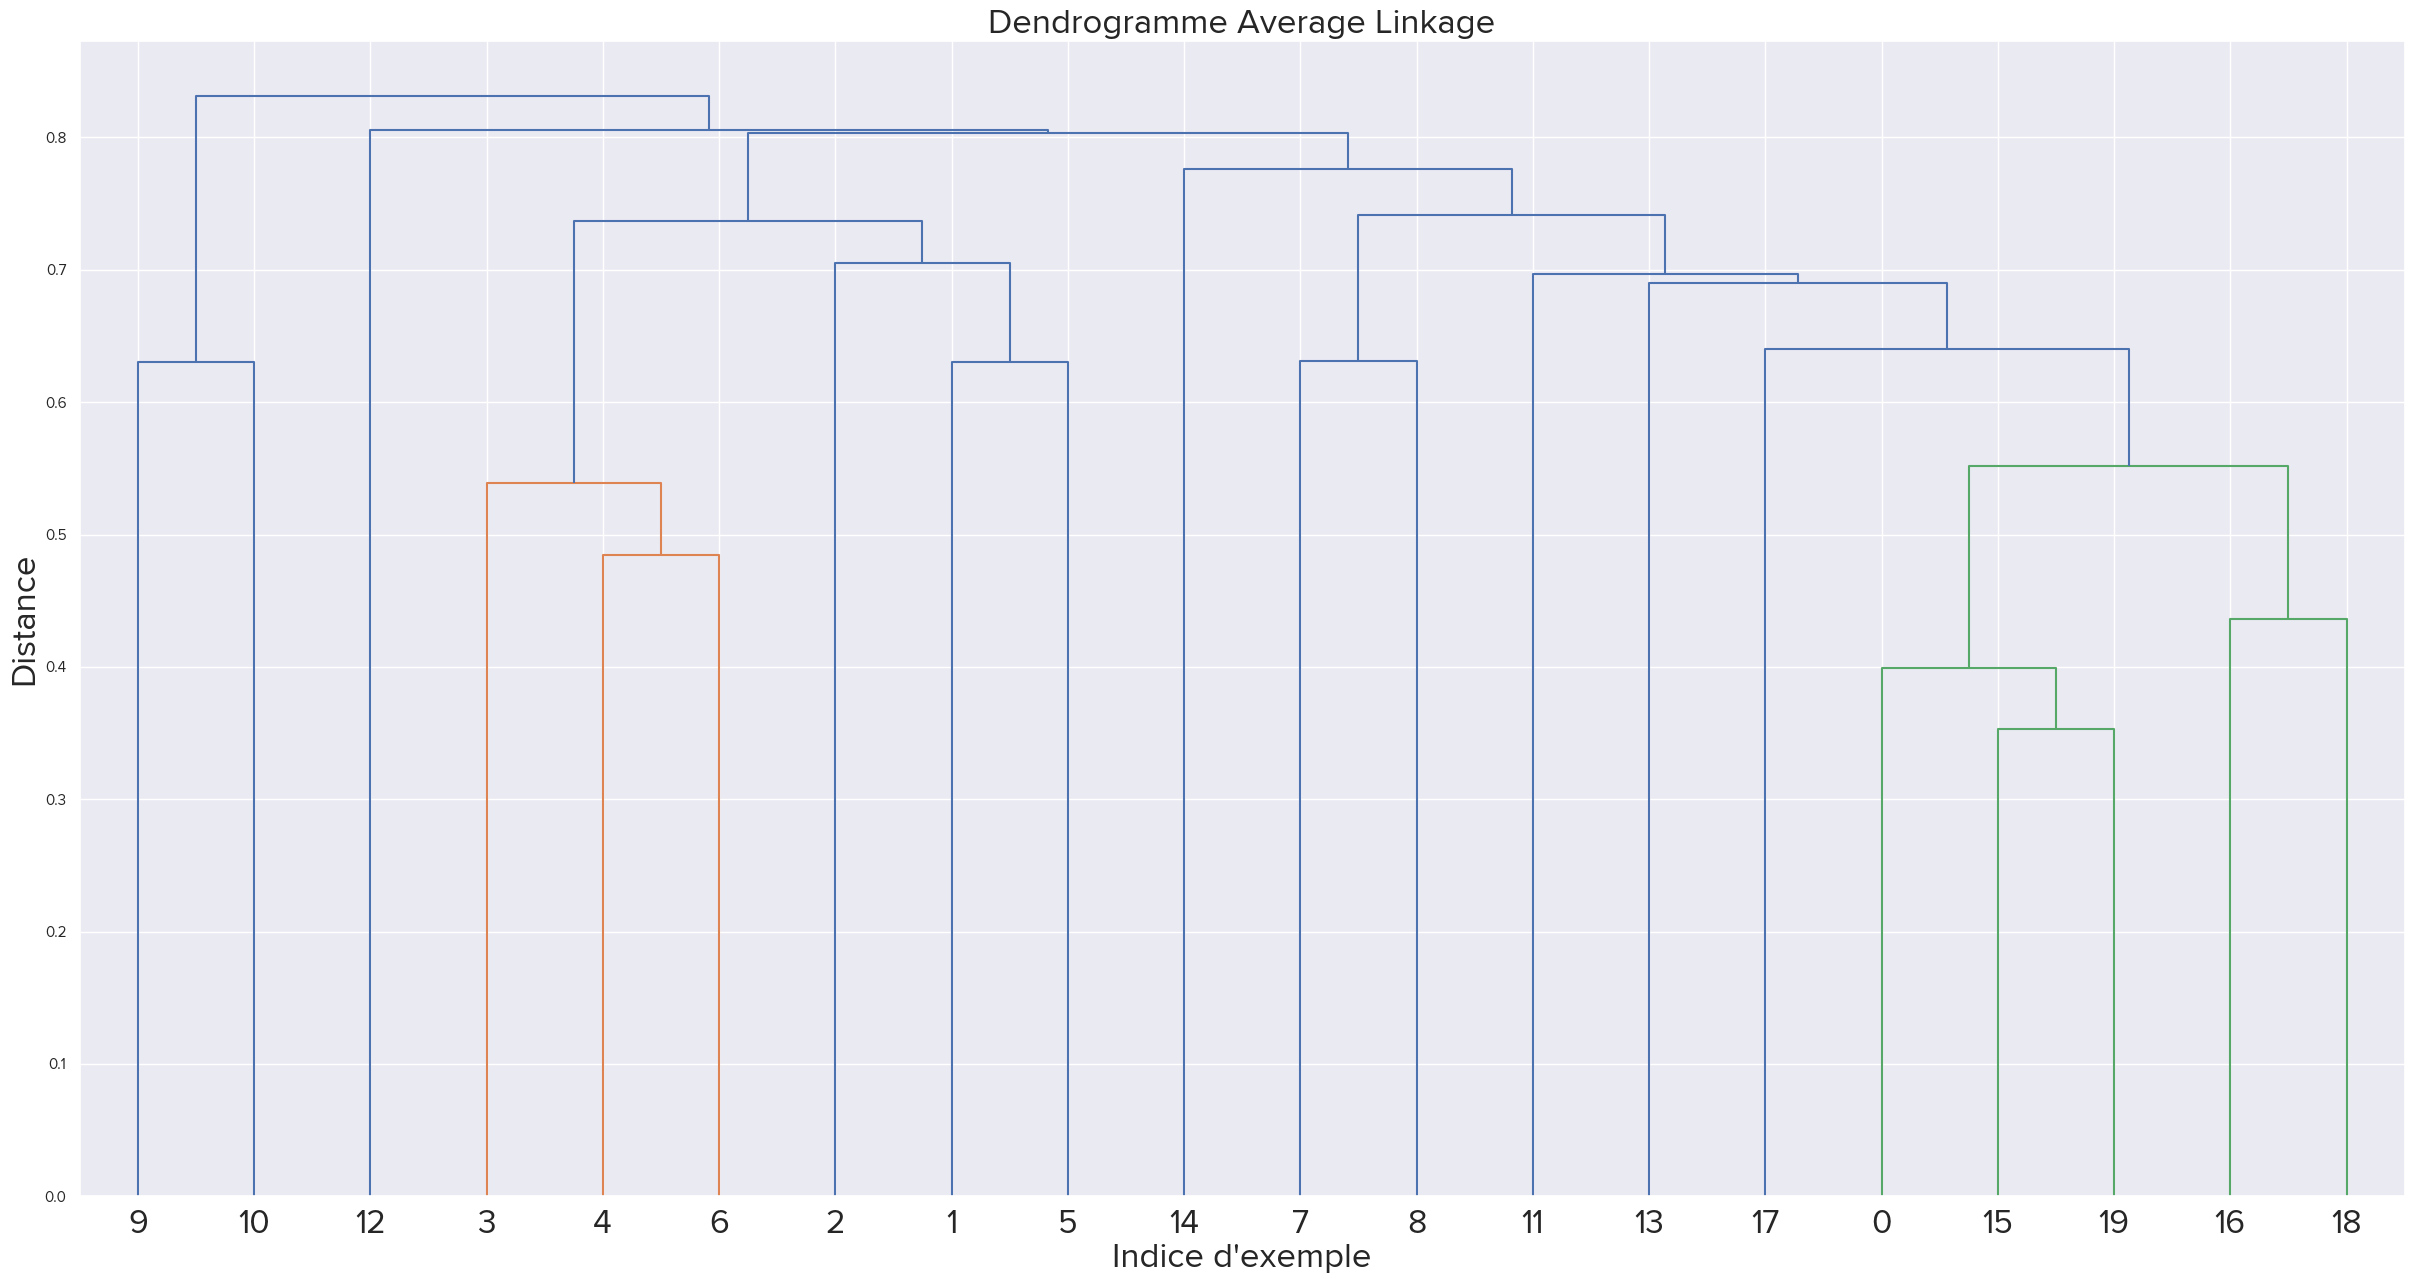

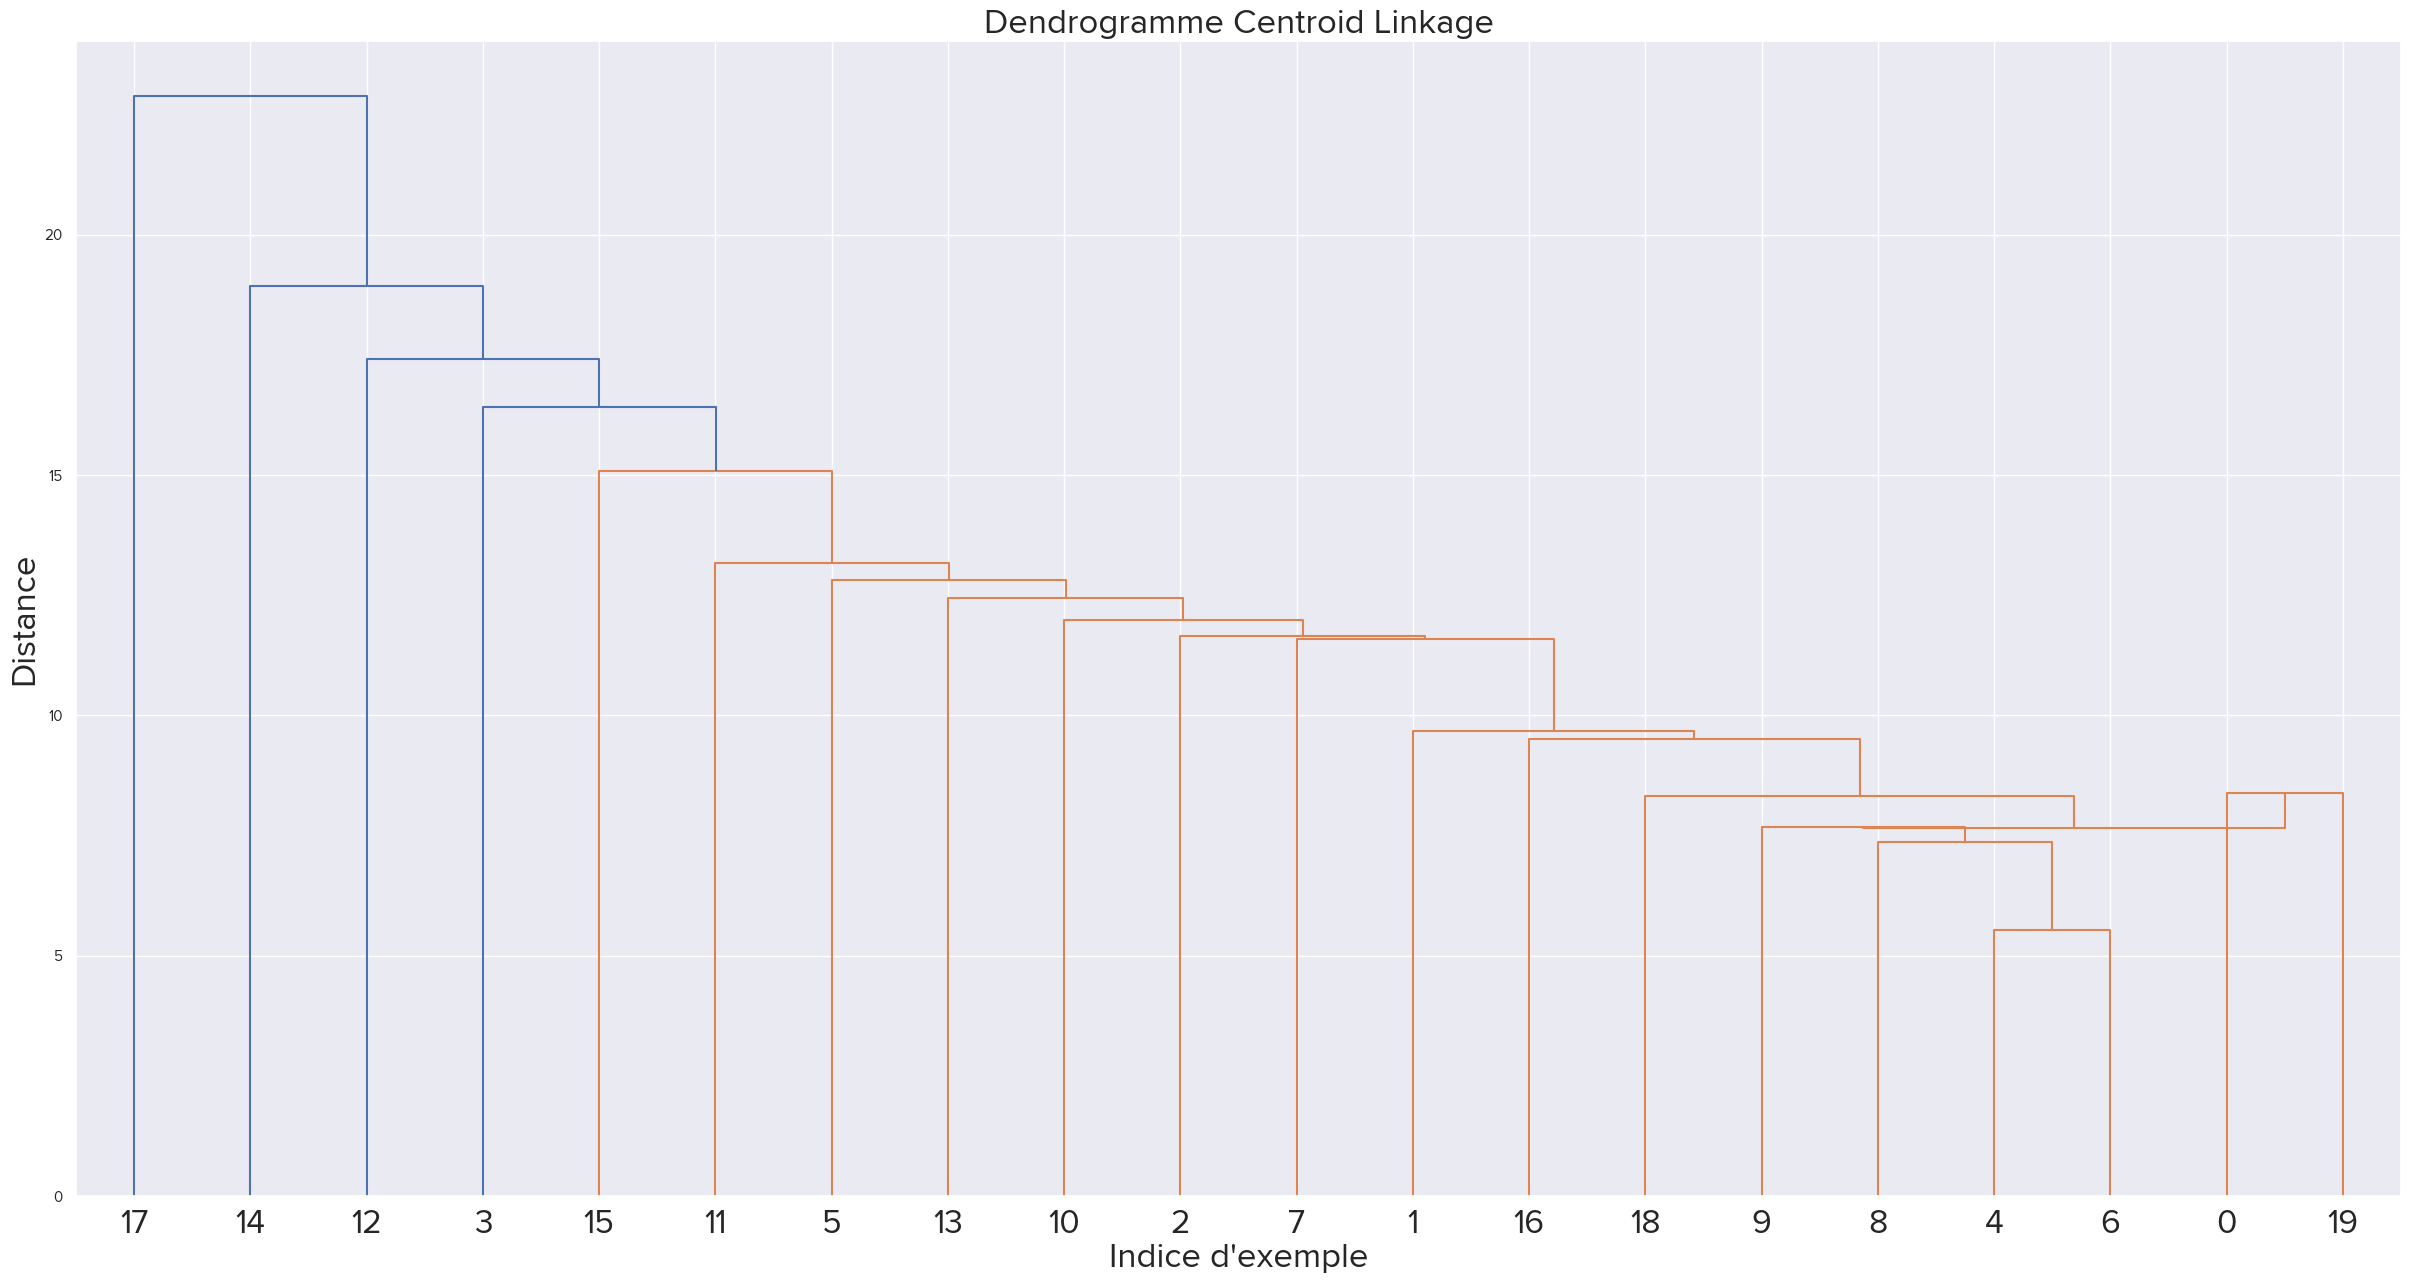

In [213]:
news_desc = get_tfidf_vect(news_no_stopwords, corpus)
targets_vectors = pd.DataFrame(ce.get_target_vectors(news_desc, news_no_stopwords))

methods = {'single':clust.CHA_simple,
           'complete':clust.CHA_complete,
           'average':clust.CHA_average,
            'centroid':clust.CHA_centroid}


for i, method in enumerate(methods):
    if method == "centroid":
        clust.CHA_centroid(targets_vectors, clust.dist_euclidienne, False, True)
    else:
        methods[method](targets_vectors, clust.dist_cosine, False, True)

`Targets` qui sont toujours groupés en 1ème ou 2ème niveau de fusion (uniquement en regardant `complete`, `simple`, `average` car ils ont donné les résultats les plus intéressants)
- 3, 4, 6 (comp.ibm.pc.hardware, comp.sys.mac.hardware, misc.forsale)
- 0, 15, 19 (alt.atheism, soc.religion.christian, talk.religion.misc)
- 16, 18 (talk.politics.misc, talk.politics.misc)
- 7, 8 (rec.autos, rec.motorcycles)
- 9, 10 (rec.sport.baseball, rec.sport.hockey)
- 1, 2, 5 (comp.graphics, comp.os.ms-windows.misc, comp.windows.x)
***

Il y a des `targets` qui sont toujours groupés en 1er-2ème niveau de fusion pour toutes les méthodes de vectorisation : 
- 3, 4 -> computers (hardware)
- 0, 15, 19 -> religion
- 16, 18 -> politics
- 1, 2, 5 -> computers (graphics & OS)
- 7, 8 -> autos & motorcycles
- 9, 10 -> sport